# MD analysis

In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
from statistics import mode
import ast
import msmexplorer as msme
from msmbuilder.utils import load,dump
import itertools
from msmbuilder.featurizer import ContactFeaturizer
from msmbuilder.featurizer import DihedralFeaturizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#XRD Ensemble
#28 4NPQ
#18 4HFI

## Default values

In [2]:
default_location = '/media/scottzhuang/data/MD/'
default_skip = 10

In [12]:
traj_notes =  [
              '4HFI_pH46_ethanol_md1','4HFI_pH46_ethanol_md2','4HFI_pH46_ethanol_md3',
                '4HFI_F238L_pH46_ethanol_md4','4HFI_F238L_pH46_ethanol_md5','4HFI_F238L_pH46_ethanol_md6','4HFI_F238L_pH46_ethanol_md1',
              '4HFI_I233T_pH46_ethanol_md1','4HFI_I233T_pH46_ethanol_md2','4HFI_I233T_pH46_ethanol_md3',
                '4HFI_F238LI233T_pH46_ethanol_md1','4HFI_F238LI233T_pH46_ethanol_md2','4HFI_F238LI233T_pH46_ethanol_md3',
              '4HFI_pH70_ethanol_md1',
              '4HFI_F238L_pH70_ethanol_md1',
              '4HFI_I233T_pH70_ethanol_md1',
              '4HFI_F238LI233T_pH70_ethanol_md1',
               '4NPQ_pH70_ethanol_md1','4NPQ_pH70_ethanol_md2','4NPQ_pH70_ethanol_md3',
              '4NPQ_F238L_pH70_ethanol_md1','4NPQ_F238L_pH70_ethanol_md2','4NPQ_F238L_pH70_ethanol_md3',
               '4NPQ_I233T_pH70_ethanol_md1','4NPQ_I233T_pH70_ethanol_md2','4NPQ_I233T_pH70_ethanol_md3',
                '4NPQ_F238LI233T_pH70_ethanol_md1','4NPQ_F238LI233T_pH70_ethanol_md2','4NPQ_F238LI233T_pH70_ethanol_md3']
default_location = '/home/scottzhuang/pdc/'
default_skip = 10

In [12]:
traj_notes =  [
              '4HFI_pH46_ethanol_md1','4HFI_pH46_ethanol_md2','4HFI_pH46_ethanol_md3',
                '4HFI_F238L_pH46_ethanol_md4','4HFI_F238L_pH46_ethanol_md5','4HFI_F238L_pH46_ethanol_md6','4HFI_F238L_pH46_ethanol_md1',
              '4HFI_I233T_pH46_ethanol_md1','4HFI_I233T_pH46_ethanol_md2','4HFI_I233T_pH46_ethanol_md3',
                '4HFI_F238LI233T_pH46_ethanol_md1','4HFI_F238LI233T_pH46_ethanol_md2','4HFI_F238LI233T_pH46_ethanol_md3',
              '4HFI_pH70_ethanol_md1',
              '4HFI_F238L_pH70_ethanol_md1',
              '4HFI_I233T_pH70_ethanol_md1',
              '4HFI_F238LI233T_pH70_ethanol_md1',
               '4NPQ_pH70_ethanol_md1','4NPQ_pH70_ethanol_md2','4NPQ_pH70_ethanol_md3',
              '4NPQ_F238L_pH70_ethanol_md1','4NPQ_F238L_pH70_ethanol_md2','4NPQ_F238L_pH70_ethanol_md3',
               '4NPQ_I233T_pH70_ethanol_md1','4NPQ_I233T_pH70_ethanol_md2','4NPQ_I233T_pH70_ethanol_md3',
                '4NPQ_F238LI233T_pH70_ethanol_md1','4NPQ_F238LI233T_pH70_ethanol_md2','4NPQ_F238LI233T_pH70_ethanol_md3']
default_location = '/home/scottzhuang/pdc/'
default_skip = 10

In [5]:
ensemble_location = '/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/'

## Steps
1. Fix periodic boundary conditions (PBC) & choose a suitable timestep.
2. transform gro file into pdb file with chain information recovered.
3. create metadata
4. calculate RMSD, RMSF, PCA... & cluster
5. extract gating features & hydration data
6. extract HBond information of TMD
7. plotting Hbond mapping & elucidate important interactions
8. geometric features (dihedral angle...)
9. analysis data

### step1
using script **pre_fixing.sh**

### Step 3

In [6]:
def create_md_dataframe():    
    md_data = pd.DataFrame(columns=list(['MD_name','pH','replicate','traj_time']))
    return md_data

In [7]:
def create_metadata(md_data= None):   
    def append_metadata(traj_note, location = default_location, skip = default_skip, md_data = md_data):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        print("In " + traj_note + ", simulation runs " + str(skip * traj.n_frames) + " ns.")
        md_name = traj_note[:traj_note.find('pH')-1]
        pH = traj_note[traj_note.find('pH')+2:traj_note.find('pH')+4]
        md_replicate = traj_note[-1]
        for i in range(0,traj.n_frames):
            md_data.loc[md_data.shape[0]+1] = [md_name,pH,md_replicate,i]

    for traj_note in traj_notes:
        append_metadata(traj_note)

In [35]:
def create_system_notation(md_data = None):
    system_notation = 0
    notation = -1
    location = default_location
    skip= default_skip

    notations = []
    increment = 0
    for traj_note in traj_notes:
        if traj_note.find('ethanol') >= 0:
            top_location = traj_note + '/' + traj_note + ".ca.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip*2) + ".ca.xtc"
        else:
            top_location = traj_note + '/' + traj_note + ".ca.gro"
            traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if traj_note.find('md1') >= 0:
            notation = notation + 1
        if traj_note.find('md4') >= 0:
            notation = notation + 1
#        if traj_note == '5NJY_I233T_pH70_md4' or traj_note == '4NPQ_pH70_md5' or  traj_note == '4NPQ_F238L_pH70_md3' or traj_note == '4NPQ_I233T_pH70_md3' or traj_note == '4NPQ_F238LI233T_pH70_md3' or traj_note == '4HFI_F238L_pH46_md4' or traj_note == '4HFI_F238L_pH46_md7':
#            notation = notation + 1

        for frame in range(0,traj.n_frames):
            notations.append(notation)
        #if increment % 3 == 2:
        #    notation = notation + 1
        #increment = increment + 1 
    md_data['system'] = notations

In [36]:
md_data_ethanol = create_md_dataframe()
create_metadata(md_data_ethanol)
create_system_notation(md_data_ethanol)

In 4HFI_pH46_ethanol_md1, simulation runs 1700 ns.
In 4HFI_pH46_ethanol_md2, simulation runs 1120 ns.
In 4HFI_pH46_ethanol_md3, simulation runs 1200 ns.
In 4HFI_F238L_pH46_ethanol_md4, simulation runs 1100 ns.
In 4HFI_F238L_pH46_ethanol_md5, simulation runs 1160 ns.
In 4HFI_F238L_pH46_ethanol_md6, simulation runs 1180 ns.
In 4HFI_F238L_pH46_ethanol_md1, simulation runs 1440 ns.
In 4HFI_I233T_pH46_ethanol_md1, simulation runs 1000 ns.
In 4HFI_I233T_pH46_ethanol_md2, simulation runs 800 ns.
In 4HFI_I233T_pH46_ethanol_md3, simulation runs 820 ns.
In 4HFI_F238LI233T_pH46_ethanol_md1, simulation runs 740 ns.
In 4HFI_F238LI233T_pH46_ethanol_md2, simulation runs 820 ns.
In 4HFI_F238LI233T_pH46_ethanol_md3, simulation runs 800 ns.
In 4HFI_pH70_ethanol_md1, simulation runs 240 ns.
In 4HFI_F238L_pH70_ethanol_md1, simulation runs 1320 ns.
In 4HFI_I233T_pH70_ethanol_md1, simulation runs 1320 ns.
In 4HFI_F238LI233T_pH70_ethanol_md1, simulation runs 220 ns.
In 4NPQ_pH70_ethanol_md1, simulation runs 

In [15]:
md_data_ethanol.to_pickle('glic_activation_ethanol.pickle')

In [35]:
md_data_235 = pd.read_pickle('glic_activation_open_235.pickle')

In [16]:
import os

In [17]:
for traj_note in traj_notes:
    try:
        print(default_location + traj_note + '/analysis/')
        os.mkdir(default_location + traj_note + '/analysis/')
    except:
        print('already exist')

/home/scottzhuang/pdc/4HFI_pH46_ethanol_md1/analysis/
already exist
/home/scottzhuang/pdc/4HFI_pH46_ethanol_md2/analysis/
already exist
/home/scottzhuang/pdc/4HFI_pH46_ethanol_md3/analysis/
already exist
/home/scottzhuang/pdc/4HFI_F238L_pH46_ethanol_md4/analysis/
already exist
/home/scottzhuang/pdc/4HFI_F238L_pH46_ethanol_md5/analysis/
already exist
/home/scottzhuang/pdc/4HFI_F238L_pH46_ethanol_md6/analysis/
already exist
/home/scottzhuang/pdc/4HFI_F238L_pH46_ethanol_md1/analysis/
already exist
/home/scottzhuang/pdc/4HFI_I233T_pH46_ethanol_md1/analysis/
already exist
/home/scottzhuang/pdc/4HFI_I233T_pH46_ethanol_md2/analysis/
already exist
/home/scottzhuang/pdc/4HFI_I233T_pH46_ethanol_md3/analysis/
already exist
/home/scottzhuang/pdc/4HFI_F238LI233T_pH46_ethanol_md1/analysis/
already exist
/home/scottzhuang/pdc/4HFI_F238LI233T_pH46_ethanol_md2/analysis/
already exist
/home/scottzhuang/pdc/4HFI_F238LI233T_pH46_ethanol_md3/analysis/
already exist
/home/scottzhuang/pdc/4HFI_pH70_ethanol_m

### Step 4

In [18]:
def create_rmsd_data(md_data= None, ref_name = None, select_domain = None):
    def append_rmsd_data(traj_note, location = default_location, ref_name = None, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        residue_selection_1 = "resSeq 13 to 198"
        residue_selection_2 = "resSeq 198 to 316"
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if select_domain == 'TMD':
            traj = traj.atom_slice(traj.topology.select(residue_selection_2))
        elif select_domain == 'ECD':
            traj = traj.atom_slice(traj.topology.select(residue_selection_1))

        if ref_name != None:
            ref_location = ("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/" + ref_name + "_1.mer.pdb")
        else:
            ref_location = location + top_location
        ref_traj = md.load(ref_location)
        if select_domain == 'TMD':
            ref_traj = ref_traj.atom_slice(ref_traj.topology.select(residue_selection_2))
        elif select_domain == 'ECD':
            ref_traj = ref_traj.atom_slice(ref_traj.topology.select(residue_selection_1))
        if traj.n_atoms != ref_traj.n_atoms:
            traj = traj.atom_slice(traj.topology.select(residue_selection))
        traj.superpose(ref_traj,0)
        rmsd_data.extend(list(md.rmsd(traj, ref_traj)*10))
    rmsd_data = []
    for traj_note in traj_notes:
        append_rmsd_data(traj_note,ref_name = ref_name)
    if select_domain == 'TMD':
        md_data['tmd_rmsd']= rmsd_data
    elif select_domain == 'ECD':
        md_data['ecd_rmsd']= rmsd_data
    elif ref_name != None:
        md_data['rmsd' + str(ref_name)]= rmsd_data
    else:
        md_data['rmsd']= rmsd_data

In [19]:
def create_pca_data(md_data = None):
    def ensemble_pca_cartesian():
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj = wholetraj.atom_slice(wholetraj.topology.select("resSeq 13 to 316"))
        wholetraj.superpose(wholetraj,18)
        pca = PCA(n_components=5)
        reduced_cartesian = pca.fit_transform(wholetraj.xyz.reshape(wholetraj.n_frames,wholetraj.n_atoms *3))
        return wholetraj, pca
    def append_pca_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top =location + top_location)
        topology = traj.topology
        traj = traj.atom_slice(topology.select("resSeq 13 to 316"))
        traj.superpose(wholetraj,18)
        traj_reduced_cartesian = pca.transform(traj.xyz.reshape(traj.n_frames,traj.n_atoms * 3))
        pca1.extend(traj_reduced_cartesian.T[0])
        pca2.extend(traj_reduced_cartesian.T[1])
        pca3.extend(traj_reduced_cartesian.T[2])
        pca4.extend(traj_reduced_cartesian.T[3])
        pca5.extend(traj_reduced_cartesian.T[4])


    pca1 = []
    pca2 = []
    pca3 = []
    pca4 = []
    pca5 = []
    wholetraj, pca = ensemble_pca_cartesian()
    for traj_note in traj_notes:
        append_pca_data(traj_note)
    md_data['wholepca_pc1'] = pca1
    md_data['wholepca_pc2'] = pca2
    md_data['wholepca_pc3'] = pca3
    md_data['wholepca_pc4'] = pca4
    md_data['wholepca_pc5'] = pca5


In [20]:
def create_cppca_data(md_data = None,residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
    def combined_ppca_reduced_cartesian(residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
        wholetraj = md.load(ensemble_location + 'new_ensemble.pdb')
        wholetraj.superpose(wholetraj,18)
        topology = wholetraj.topology
        wholetraj_sliced_ecd = wholetraj.atom_slice(topology.select(residue_selection_1))
        wholetraj_sliced_ecd.superpose(wholetraj_sliced_ecd,18)
        wholetraj_sliced_tmd = wholetraj.atom_slice(topology.select(residue_selection_2))
        wholetraj_sliced_tmd.superpose(wholetraj_sliced_tmd,18)
        ppca_ecd = PCA(n_components=2)
        ppca_tmd = PCA(n_components=2)
        partial_reduced_cartesian = [ppca_ecd.fit_transform(wholetraj_sliced_ecd.xyz.reshape(wholetraj_sliced_ecd.n_frames, wholetraj_sliced_ecd.n_atoms * 3)), ppca_tmd.fit_transform(wholetraj_sliced_tmd.xyz.reshape(wholetraj_sliced_tmd.n_frames, wholetraj_sliced_tmd.n_atoms * 3))]    
        return partial_reduced_cartesian, wholetraj_sliced_ecd, wholetraj_sliced_tmd,ppca_ecd,ppca_tmd
    
    def append_projection_on_combined_ppca_data(traj_note, location = default_location, skip = default_skip, residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        topology = traj.topology
        traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))

        traj_sliced_ecd.superpose(wholetraj_sliced_ecd,18)
        traj_sliced_tmd.superpose(wholetraj_sliced_tmd,18)

        reduced_cartesian_ecd_pc1.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[0])
        reduced_cartesian_ecd_pc2.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[1])
        reduced_cartesian_tmd_pc1.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[0])
        reduced_cartesian_tmd_pc2.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[1])

    partial_reduced_cartesian, wholetraj_sliced_ecd,wholetraj_sliced_tmd, ppca_ecd,ppca_tmd = combined_ppca_reduced_cartesian(residue_selection_1,residue_selection_2)
    
    reduced_cartesian_ecd_pc1 = []
    reduced_cartesian_ecd_pc2 = []
    reduced_cartesian_tmd_pc1 = []
    reduced_cartesian_tmd_pc2 = []

    for traj_note in traj_notes:
        append_projection_on_combined_ppca_data(traj_note)
    md_data['ecd_pc1']= reduced_cartesian_ecd_pc1
    md_data['ecd_pc2']= reduced_cartesian_ecd_pc2
    md_data['tmd_pc1']= reduced_cartesian_tmd_pc1
    md_data['tmd_pc2']= reduced_cartesian_tmd_pc2

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, feature):
        

        ss = StandardScaler()
        X = ss.fit_transform(feature[['ecd_pc1','tmd_pc1']].values)
        
        return X
    
    
    def predict(self, feature):
        
        X = self._preprocess(feature)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels


In [ ]:
md_data['dbscan'] = 0
for system in range(0,8):
    md_data.loc[(md_data.system == system) & (md_data.traj_time < 5),'dbscan'] = -1    
for system in range(8,16):
    model = Clusterer(eps=0.2)
    label = model.predict(md_data[md_data.system == system])
    md_data.loc[md_data.system == system,'dbscan'] = label
    md_data.loc[(md_data.system == system) & (md_data.dbscan != mode(label)),'dbscan'] = -1
    md_data.loc[(md_data.system == system) & (md_data.dbscan == mode(label)),'dbscan'] = 0

In [38]:
create_rmsd_data(md_data_ethanol)
create_pca_data(md_data_ethanol)
create_cppca_data(md_data_ethanol)

### Step 5
Preprocess: run **helix_tilt.sh** & **helix_twist.sh**

In [23]:
def create_domain_twist_data(md_data = None):
    def append_domain_twist(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)        
        traj.superpose(traj,0)
        topology = traj.topology
        domain_twist = []
        for chain in range (0,5):
            residue_selection_1 = "resid " + str(8+chain*311) + " to " + str(192+chain*311)
            residue_selection_2 = "resid " + str(192+chain*311) + " to " + str(310+chain*311)
            traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
            traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))
            angle = []
            for i in range(0,traj.n_frames):
                cen_mass_ecd = md.compute_center_of_mass(traj_sliced_ecd[i])[0]
                cen_mass_tmd = md.compute_center_of_mass(traj_sliced_tmd[i])[0]
                cen_mass = md.compute_center_of_mass(traj[i])[0]
                cen_mass_ecd[2] = cen_mass[2]
                cen_mass_tmd[2] = cen_mass[2]
                vec_ecd = cen_mass_ecd - cen_mass
                vec_tmd = cen_mass_tmd - cen_mass
                veclength_ecd = np.sqrt(np.sum(np.power(vec_ecd,2)))
                veclength_tmd = np.sqrt(np.sum(np.power(vec_tmd,2)))
                angle.append(57.2958 * np.arccos(np.dot(vec_ecd,vec_tmd) /(veclength_ecd * veclength_tmd)))
            domain_twist.append(angle)
        domain_twist_data.extend(np.mean(np.asarray(domain_twist),axis=0))
    domain_twist_data = []
    for traj_note in traj_notes:
        append_domain_twist(traj_note)
    md_data['domain twist']= domain_twist_data

In [51]:
def create_helix_tilt_data(md_data = None):
    def append_helix_tilt_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        tilt_data = pd.read_csv(location + traj_note + '/analysis/' + traj_note + '.tilt.csv',sep=" ")
        tilt_data.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        helix_tilt_data.extend(tilt_data['avg'])
    helix_tilt_data = []
    for traj_note in traj_notes:
        append_helix_tilt_data(traj_note)
    md_data['helix tilt angle'] = helix_tilt_data

In [49]:
def create_helix_twist_data(md_data = None):
    def append_helix_twist_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        twist = pd.read_csv(location + traj_note + '/analysis/' + traj_note + '.twist.csv',sep=" ")
        twist.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        helix_twist_data.extend(twist['avg'])
    helix_twist_data = []
    for traj_note in traj_notes:
        append_helix_twist_data(traj_note)
    md_data['helix twist angle'] = helix_twist_data

In [26]:
def create_beta_expansion(md_data = None):
    def append_beta_expansion_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        distance = []
        for chain in range(0,5):
            distance.append(md.compute_distances(traj,[[27 + chain * 311,187 + chain * 311]]))
        beta_expansion_data.extend(np.mean(distance,axis=0).T[0])
    beta_expansion_data = []
    for traj_note in traj_notes:
        append_beta_expansion_data(traj_note)
    md_data['beta_expansion'] = beta_expansion_data

In [27]:
def create_M2_radius(md_data = None):
    def append_M2_radius_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        M2_selection = 'resSeq 231 to 245'
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        M2_radius_data.extend(md.compute_rg(traj_M2).T) 
    M2_radius_data = []
    for traj_note in traj_notes:
        append_M2_radius_data(traj_note)
    md_data['M2_radius'] = M2_radius_data

In [28]:
def create_ECD_radius(md_data = None):
    def append_ECD_radius_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        ECD_selection = 'resSeq 5 to 194'
        traj_ECD = traj.atom_slice(topology.select(ECD_selection))
        ECD_radius_data.extend(md.compute_rg(traj_ECD).T) 
    ECD_radius_data = []
    for traj_note in traj_notes:
        append_ECD_radius_data(traj_note)
    md_data['ECD_radius'] = ECD_radius_data

In [29]:
def create_M2_M1_distance(md_data = None):
    def distance_calculate(x,y):
        dist = np.sqrt(np.power(x[0]-y[0],2) + np.power(x[1]-y[1],2) + np.power(x[2]-y[2],2))
        return dist
    def append_M2_M1_distance_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        distance = []
        for chain in range(0,4):
            M1_selection = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M2_selection = 'resid ' + str(233 + (chain + 1) * 311) + ' to ' + str(238 + (chain + 1) * 311)
            traj_M1 = traj.atom_slice(topology.select(M1_selection))
            traj_M2 = traj.atom_slice(topology.select(M2_selection))
            distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        M1_selection = 'resid ' + str(192 + 4 * 311) + ' to ' + str(196 + 4 * 311)
        M2_selection = 'resid ' + str(233) + ' to ' + str(238)
        traj_M1 = traj.atom_slice(topology.select(M1_selection))
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        #print((np.mean(np.asarray(distance),axis=0))
        M2_M1_distance.extend(np.mean(distance,axis=0))
    M2_M1_distance = []
    for traj_note in traj_notes:
        append_M2_M1_distance_data(traj_note)
    md_data['M2_M1_distance'] = M2_M1_distance
    #print(M2_M1_distance)

In [30]:
def create_M2_M1_distance_per_chain(md_data = None):
    def distance_calculate(x,y):
        dist = np.sqrt(np.power(x[0]-y[0],2) + np.power(x[1]-y[1],2) + np.power(x[2]-y[2],2))
        return dist
    def append_M2_M1_distance_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        distance = []
        for chain in range(0,4):
            M1_selection = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M2_selection = 'resid ' + str(233 + (chain + 1) * 311) + ' to ' + str(238 + (chain + 1) * 311)
            traj_M1 = traj.atom_slice(topology.select(M1_selection))
            traj_M2 = traj.atom_slice(topology.select(M2_selection))
            distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))

        M1_selection = 'resid ' + str(192 + 4 * 311) + ' to ' + str(196 + 4 * 311)
        M2_selection = 'resid ' + str(233) + ' to ' + str(238)
        traj_M1 = traj.atom_slice(topology.select(M1_selection))
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        #print((np.mean(np.asarray(distance),axis=0))
        M2_M1_distance_1.extend(distance[0])
        M2_M1_distance_2.extend(distance[1])
        M2_M1_distance_3.extend(distance[2])
        M2_M1_distance_4.extend(distance[3])
        M2_M1_distance_5.extend(distance[4])

    M2_M1_distance_1 = []
    M2_M1_distance_2 = []
    M2_M1_distance_3 = []
    M2_M1_distance_4 = []
    M2_M1_distance_5 = []

    for traj_note in traj_notes:
        append_M2_M1_distance_data(traj_note)
    md_data['M2_M1_distance_1'] = M2_M1_distance_1
    md_data['M2_M1_distance_2'] = M2_M1_distance_2
    md_data['M2_M1_distance_3'] = M2_M1_distance_3
    md_data['M2_M1_distance_4'] = M2_M1_distance_4
    md_data['M2_M1_distance_5'] = M2_M1_distance_5

    #print(M2_M1_distance)

In [31]:
def create_M1_kink(md_data = None):
    def angle_calculate(x,y,z):
        angle_set = []
        for i in range(0,x.shape[0]):
            angle_set.append(180 - 57.29 * np.arccos(np.dot((x[i]-y[i]),(z[i]-y[i]))/(np.linalg.norm(x[i]-y[i]) * np.linalg.norm(z[i]-y[i]))))
        return angle_set
    def append_M1_kink_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        angle = []
        for chain in range(0,5):
            M1_selection_up = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M1_selection_mid = 'resid ' + str(194 + chain * 311) + ' to ' + str(198 + chain * 311)
            M1_selection_down = 'resid ' + str(197 + chain * 311) + ' to ' + str(208 + chain * 311)

            M1_up = traj.atom_slice(topology.select(M1_selection_up))
            M1_mid = traj.atom_slice(topology.select(M1_selection_mid))
            M1_down = traj.atom_slice(topology.select(M1_selection_down))
            angle.append(angle_calculate(md.compute_center_of_mass(M1_up), md.compute_center_of_mass(M1_mid), md.compute_center_of_mass(M1_down)))
        M1_kink.extend(np.mean(angle,axis=0))
    M1_kink = []
    for traj_note in traj_notes:
        append_M1_kink_data(traj_note)
    md_data['M1_kink'] = M1_kink


In [32]:
def create_M2_kink(md_data = None):
    def angle_calculate(x,y,z):
        angle_set = []
        for i in range(0,x.shape[0]):
            angle_set.append(180 - 57.29 * np.arccos(np.dot((x[i]-y[i]),(z[i]-y[i]))/(np.linalg.norm(x[i]-y[i]) * np.linalg.norm(z[i]-y[i]))))
        return angle_set
    def append_M2_kink_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        angle = []
        for chain in range(0,5):
            M2_selection_up = 'resid ' + str(216 + chain * 311) + ' to ' + str(233 + chain * 311)
            M2_selection_mid = 'resid ' + str(233 + chain * 311) + ' to ' + str(233 + chain * 311)
            M2_selection_down = 'resid ' + str(233 + chain * 311) + ' to ' + str(240 + chain * 311)

            M2_up = traj.atom_slice(topology.select(M2_selection_up))
            M2_mid = traj.atom_slice(topology.select(M2_selection_mid))
            M2_down = traj.atom_slice(topology.select(M2_selection_down))
            angle.append(angle_calculate(md.compute_center_of_mass(M2_up), md.compute_center_of_mass(M2_mid), md.compute_center_of_mass(M2_down)))
        M2_kink.extend(np.mean(angle,axis=0))
    M2_kink = []
    for traj_note in traj_notes:
        append_M2_kink_data(traj_note)
    md_data['M2_kink'] = M2_kink


In [39]:
create_domain_twist_data(md_data_ethanol)

In [46]:

create_beta_expansion(md_data_ethanol)
create_M2_radius(md_data_ethanol)
create_ECD_radius(md_data_ethanol)
create_M2_M1_distance(md_data_ethanol)
create_M1_kink(md_data_ethanol)
create_M2_kink(md_data_ethanol)

In [62]:
#create_helix_tilt_data(md_data_ethanol)
create_helix_twist_data(md_data_ethanol)

In [63]:
create_helix_tilt_data(md_data_ethanol)


1606


In [56]:
def create_pore_profile(md_data = None):
    def pore_rad(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".protein.gro"
        traj_name = traj_note + '/' + traj_note + ".skip" + str(skip) + ".protein.xtc"    
        traj = md.load(location + traj_name,top = location + top_location)
        ca_top_location = traj_note + '/' + traj_note +  ".ca.pdb"
        ca_traj_name = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"    
        ca_traj = md.load(location + ca_traj_name,top = location + ca_top_location)
        topology = traj.topology
        pore_profile = pd.DataFrame(columns=['traj_time','resid','pore_radius'])
        m = 0
        incre = 0
        for i in [217,221,225,228,232,235]:
            group_1 = np.arange(i,i + 1245, 311)
            xyz_inter = np.mean(ca_traj.xyz[:,group_1],axis=1)
            chain = topology.add_chain()
            residue = topology.add_residue('ALA',chain)
            topology.add_atom('H','H',residue)
            traj.topology = topology
            traj.xyz = np.append(traj.xyz,xyz_inter.reshape([traj.n_frames,1,3]),axis=1)
            pairs = list(itertools.product(group_1,[1555 + incre]))
            for j in range(0,traj.n_frames):
                pore_profile.loc[m] = [j,i,np.mean(md.compute_contacts(traj[j], pairs)[0])]
                m = m + 1
            incre = incre +1
        pore_data_222.extend(pore_profile[pore_profile['resid'] == 217]['pore_radius'])
        pore_data_226.extend(pore_profile[pore_profile['resid'] == 221]['pore_radius'])
        pore_data_230.extend(pore_profile[pore_profile['resid'] == 225]['pore_radius'])
        pore_data_233.extend(pore_profile[pore_profile['resid'] == 228]['pore_radius'])
        pore_data_237.extend(pore_profile[pore_profile['resid'] == 232]['pore_radius'])
        pore_data_240.extend(pore_profile[pore_profile['resid'] == 235]['pore_radius'])
    import itertools
    pore_data_222 = []
    pore_data_226 = []
    pore_data_230 = []
    pore_data_233 = []
    pore_data_237 = []
    pore_data_240 = []

    for traj_note in traj_notes:
        pore_rad(traj_note)
    md_data['pore_profile_222'] = pore_data_222
    md_data['pore_profile_226'] = pore_data_226
    md_data['pore_profile_230'] = pore_data_230
    md_data['pore_profile_233'] = pore_data_233
    md_data['pore_profile_237'] = pore_data_237
    md_data['pore_profile_240'] = pore_data_240

In [57]:
def create_ethanol_profile(md_data = None):
    def append_hydration_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 10 -10 resid 235) and resname LIG",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['pore_ethanol_data'] = hydration_data

In [58]:
def create_hydration_profile_2(md_data = None):
    def append_hydration_data(traj_note, location = default_location, skip = default_skip):
        if traj_note.find('ethanol') >= 0:
            skip = skip * 2
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 8 -8 resid 236) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_236_center'] = hydration_data

In [305]:
def create_intersubunit_ethanol_data(md_data = None):
    def create_intersubunit_ethanol_data(traj_note):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip20.system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('resname LIG and (around 6 (resid 200 and segid ' + subunit_dic[subunit]  + ')) and (around 6 (resid 263 and segid ' + subunit_dic[subunit+1] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intersubunit_ethanol'] = ethanol_data

In [366]:
def create_intersubunit_ethanol_data_2(md_data = None):
    def create_intersubunit_ethanol_data(traj_note):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip20.system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in [4,0,1,2,3]:
            ethanolation = traj.select_atoms('resname LIG and (around 6 (resid 200 and segid ' + subunit_dic[subunit]  + ')) and (around 6 (resid 263 and segid ' + subunit_dic[subunit+1] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intersubunit_ethanol_left'] = ethanol_data

In [366]:
def create_intersubunit_ethanol_data_3(md_data = None):
    def create_intersubunit_ethanol_data(traj_note):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip20.system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('resname LIG and (around 6 (resid 250 and segid ' + subunit_dic[subunit]  + ')) and (around 6 (resid 235 and segid ' + subunit_dic[subunit] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intrasubunit_ethanol_250'] = ethanol_data

In [370]:
def create_intrasubunit_ethanol_data(md_data = None):
    def create_intersubunit_ethanol_data(traj_note):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip20.system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        for subunit in range(0,5):
            ethanolation = traj.select_atoms('resname LIG and (around 6 (resid 202 and segid ' + subunit_dic[subunit]  + ')) and (around 6 (resid 235 and segid ' + subunit_dic[subunit] + '))' , updating = True)
            for i in range(0,traj.trajectory.n_frames):
                traj.trajectory[i]
                traj_ethanol_data.append(ethanolation.n_atoms)
        ethanol_data.extend(list(np.asarray(traj_ethanol_data).reshape(5,traj.trajectory.n_frames).T.ravel()))

    ethanol_data = []
    for traj_note in traj_notes:
        traj_ethanol_data = []
        create_intersubunit_ethanol_data(traj_note)
    #return ethanol_data
    #ethanol_data = np.asarray(ethanol_data).reshape(traj.trajectory.n_frames,5).T.ravel()
    md_data['intrasubunit_ethanol'] = ethanol_data

In [323]:
def create_pore_ethanol_data_1(md_data = None):
    def create_intersubunit_ethanol_data(traj_note):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip20.system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        ethanolation = traj.select_atoms('resname LIG and cyzone 7 3 -3 resid 233',updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            for subunit in range(0,5):
                ethanol_data.append(ethanolation.n_atoms)
    ethanol_data = []
    for traj_note in traj_notes:
        create_intersubunit_ethanol_data(traj_note)
    md_data['233_ethanol'] = ethanol_data

In [311]:
def create_pore_ethanol_data_2(md_data = None):
    def create_intersubunit_ethanol_data(traj_note):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip20.system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        ethanolation = traj.select_atoms('resname LIG and cyzone 7 3 -3 resid 240',updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            for subunit in range(0,5):
                ethanol_data.append(ethanolation.n_atoms)
    ethanol_data = []
    for traj_note in traj_notes:
        create_intersubunit_ethanol_data(traj_note)
    md_data['240_ethanol'] = ethanol_data

In [312]:
def create_pore_ethanol_data(md_data = None):
    def create_intersubunit_ethanol_data(traj_note):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip20.system.xtc"
        traj = mda.Universe(default_location + top_location,default_location + traj_location)
        ethanolation = traj.select_atoms('resname LIG and cyzone 7 8 -8 resid 236',updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            for subunit in range(0,5):
                ethanol_data.append(ethanolation.n_atoms)
    ethanol_data = []
    for traj_note in traj_notes:
        create_intersubunit_ethanol_data(traj_note)
    md_data['pore_ethanol'] = ethanol_data

In [59]:
create_pore_profile(md_data_ethanol)
create_hydration_profile_2(md_data_ethanol)

In [60]:
create_ethanol_profile(md_data_ethanol)

In [64]:
md_data_ethanol.to_pickle('glic_ethanol.pickle')

In [12]:
traj_notes =  [
              '4HFI_pH46_ethanol_md1','4HFI_pH46_ethanol_md2','4HFI_pH46_ethanol_md3',
                '4HFI_F238L_pH46_ethanol_md4','4HFI_F238L_pH46_ethanol_md5','4HFI_F238L_pH46_ethanol_md6','4HFI_F238L_pH46_ethanol_md1',
              '4HFI_I233T_pH46_ethanol_md1','4HFI_I233T_pH46_ethanol_md2','4HFI_I233T_pH46_ethanol_md3',
                '4HFI_F238LI233T_pH46_ethanol_md1','4HFI_F238LI233T_pH46_ethanol_md2','4HFI_F238LI233T_pH46_ethanol_md3',
              '4HFI_pH70_ethanol_md1',
              '4HFI_F238L_pH70_ethanol_md1',
              '4HFI_I233T_pH70_ethanol_md1',
              '4HFI_F238LI233T_pH70_ethanol_md1',
               '4NPQ_pH70_ethanol_md1','4NPQ_pH70_ethanol_md2','4NPQ_pH70_ethanol_md3',
              '4NPQ_F238L_pH70_ethanol_md1','4NPQ_F238L_pH70_ethanol_md2','4NPQ_F238L_pH70_ethanol_md3',
               '4NPQ_I233T_pH70_ethanol_md1','4NPQ_I233T_pH70_ethanol_md2','4NPQ_I233T_pH70_ethanol_md3',
                '4NPQ_F238LI233T_pH70_ethanol_md1','4NPQ_F238LI233T_pH70_ethanol_md2','4NPQ_F238LI233T_pH70_ethanol_md3']
default_location = '/home/scottzhuang/pdc/'
default_skip = 10

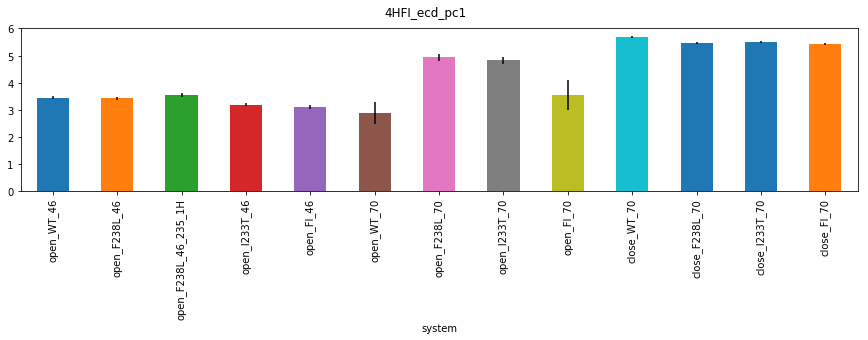

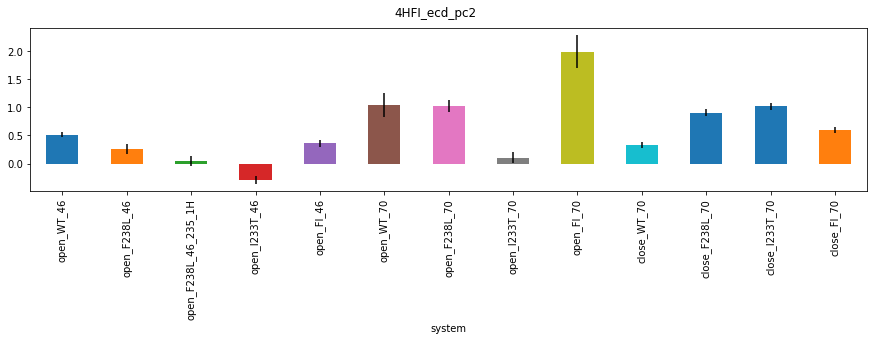

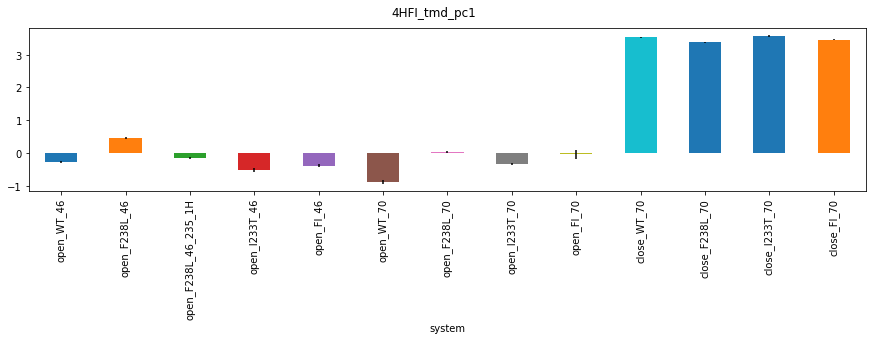

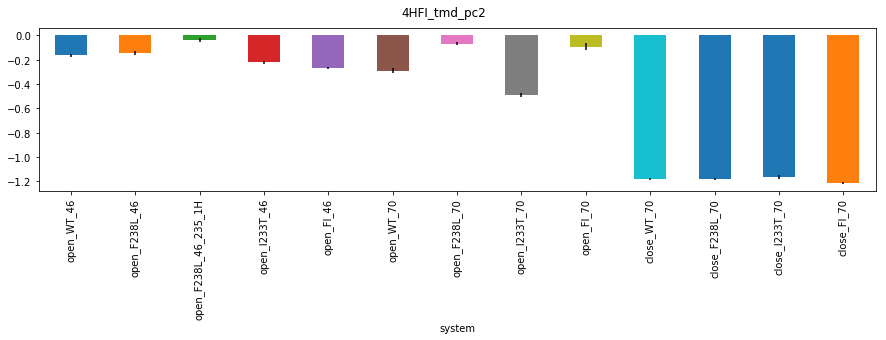

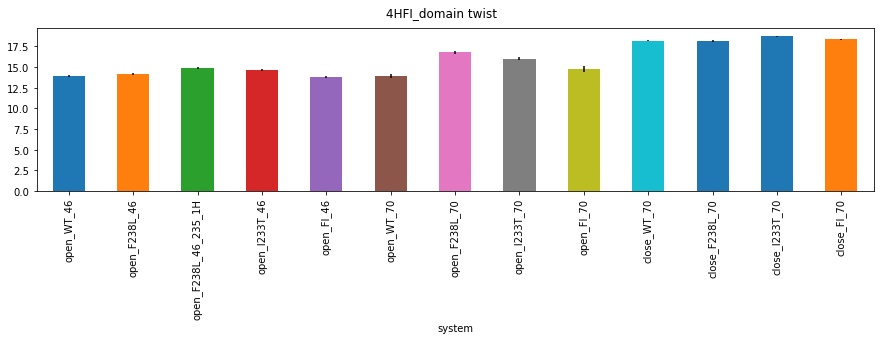

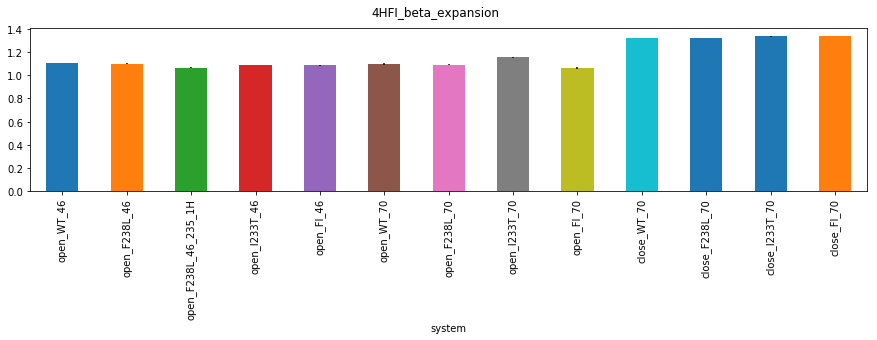

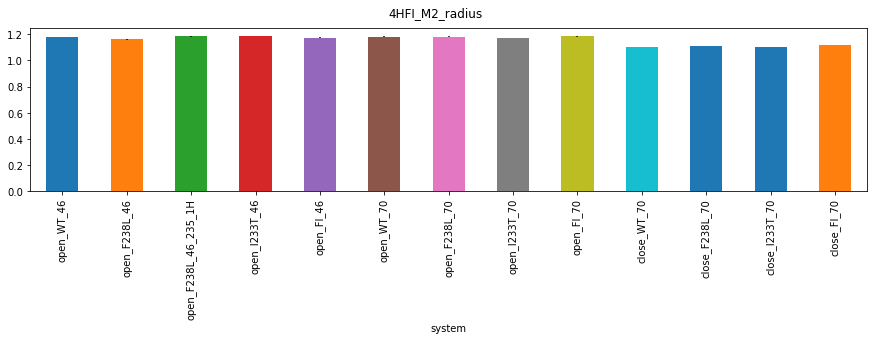

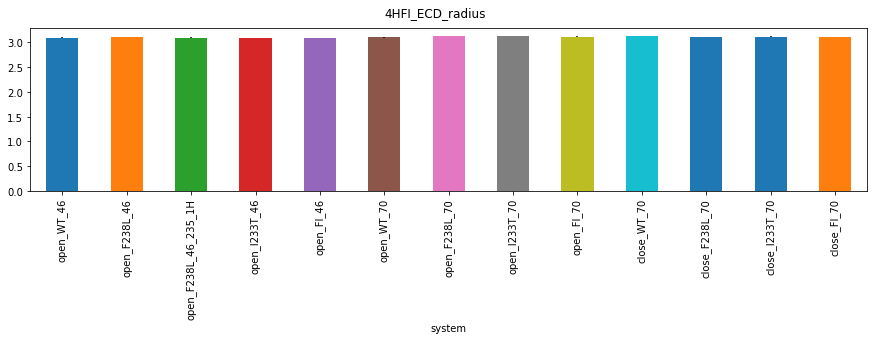

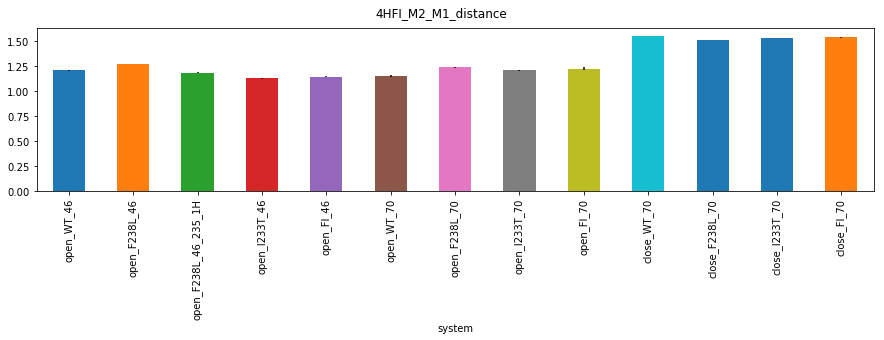

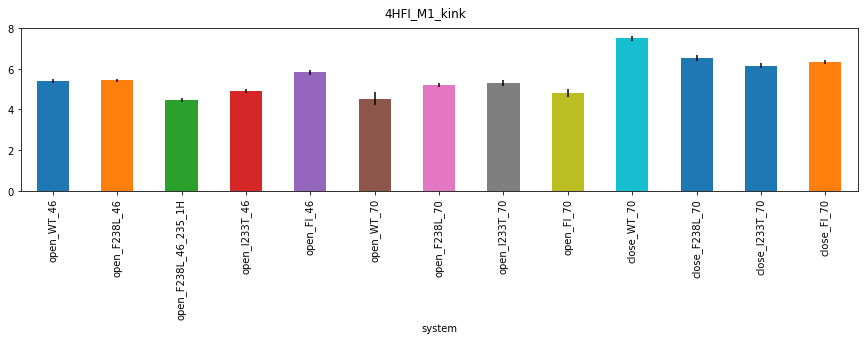

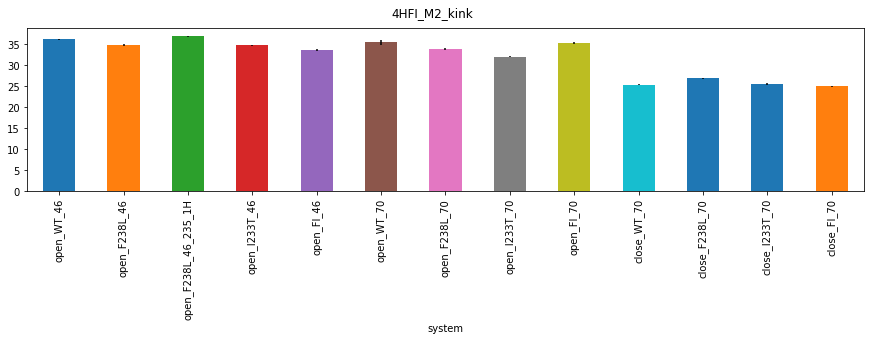

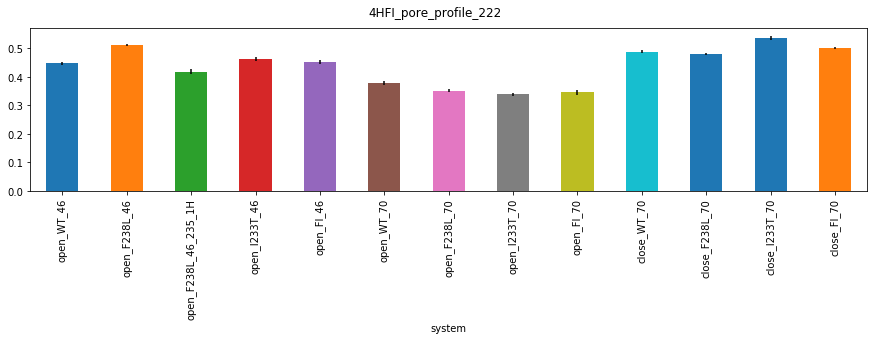

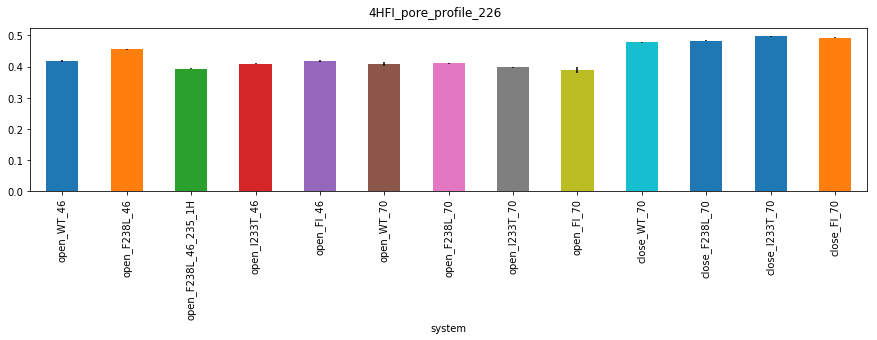

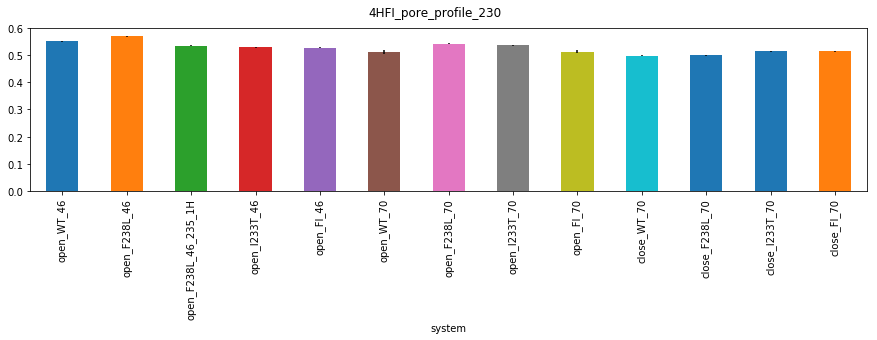

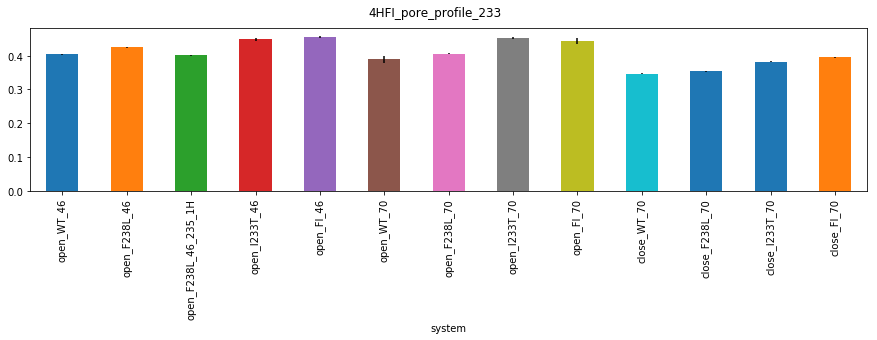

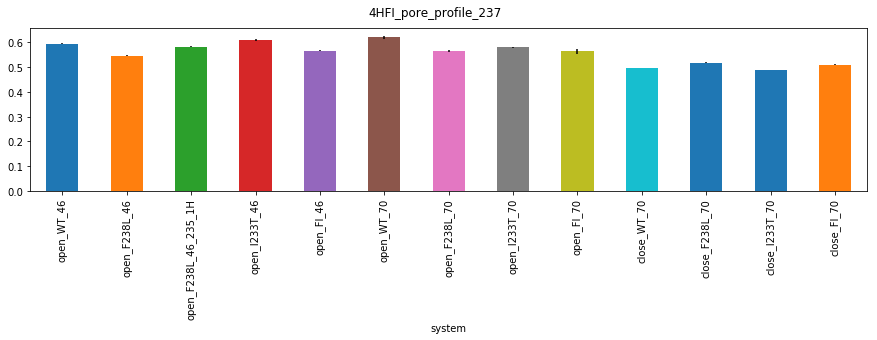

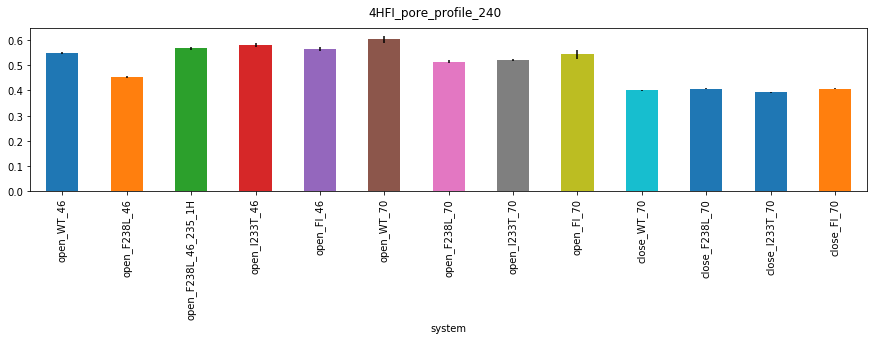

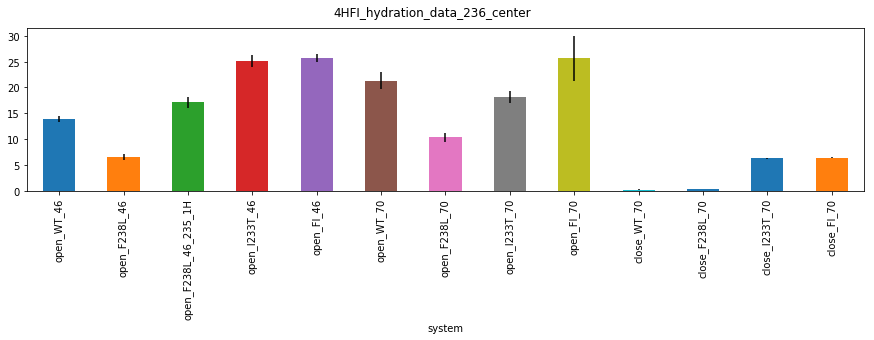

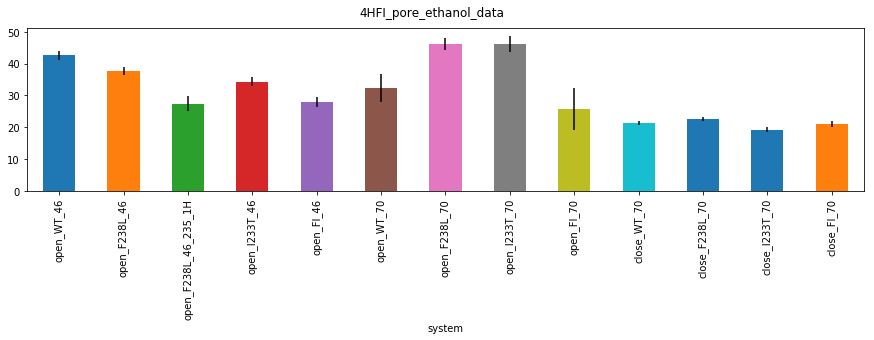

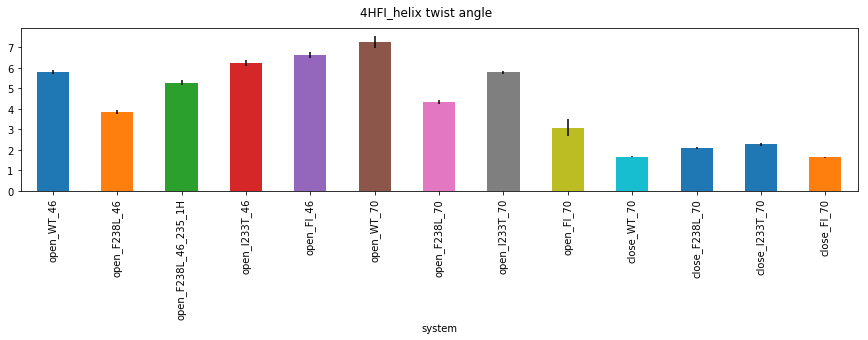

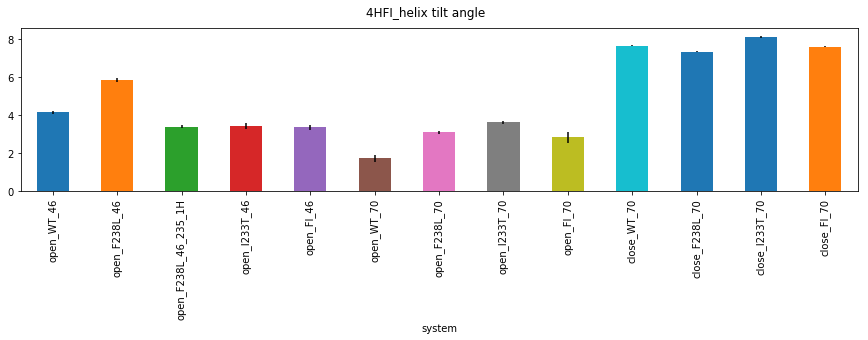

In [73]:
for feature in md_data_ethanol.columns[11:]:
#    if md_data_235[md_data_235.system == 0][feature].mean() > 2 or md_data_235[md_data_235.system == 1][feature].mean() > 2:
    fig, ax = plt.subplots(figsize=(15, 3))
#        md_data_235[md_data_235.replicate == '4'].plot(x='traj_time',y=feature,ax=ax[0],label='4',c='blue')
#        md_data_235[md_data_235.replicate == '5'].plot(x='traj_time',y=feature,ax=ax[0],label='5',c='blue')
#        md_data_235[md_data_235.replicate == '6'].plot(x='traj_time',y=feature,ax=ax[0],label='6',c='blue')
#        md_data_235[md_data_235.replicate == '7'].plot(x='traj_time',y=feature,ax=ax[0],label='7',c='red')
#        md_data_235[md_data_235.replicate == '8'].plot(x='traj_time',y=feature,ax=ax[0],label='8',c='red')
#        md_data_235[md_data_235.replicate == '9'].plot(x='traj_time',y=feature,ax=ax[0],label='9',c='red')
#        ax[0].set_xlim(0,90)
    fig.suptitle('4HFI_' + feature)
    group = md_data_ethanol.groupby(['system'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_F238L_46_235_1H','open_I233T_46','open_FI_46','open_WT_70','open_F238L_70','open_I233T_70','open_FI_70','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


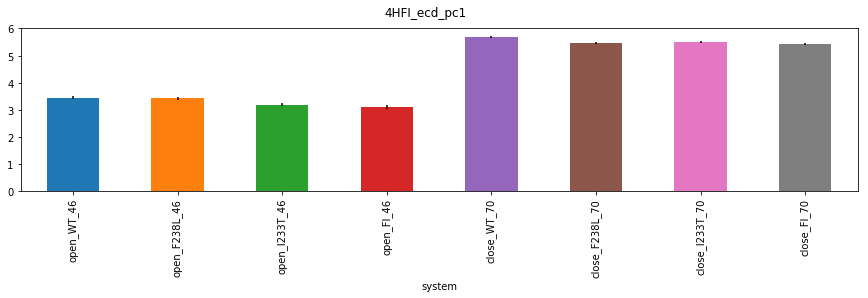

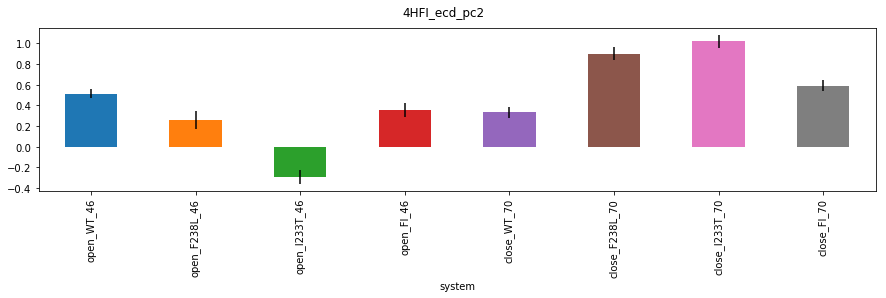

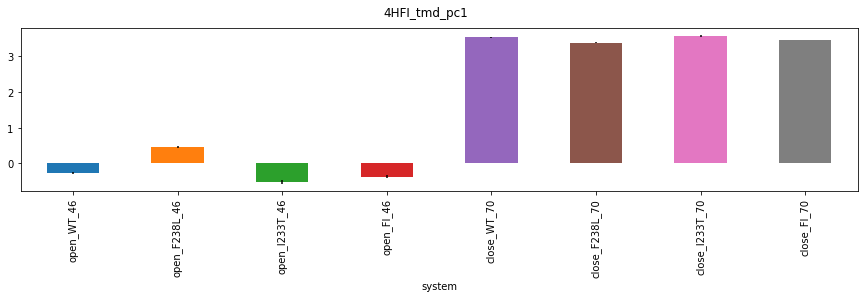

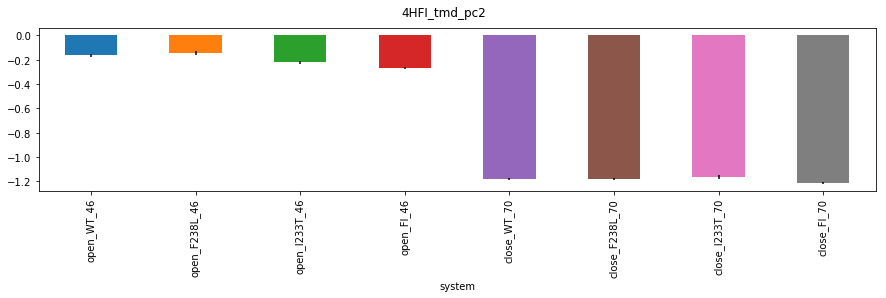

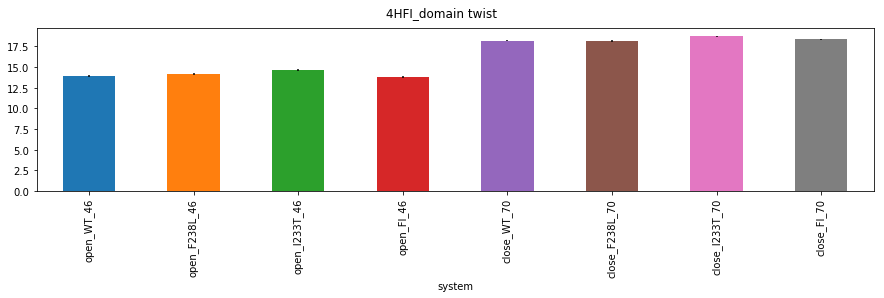

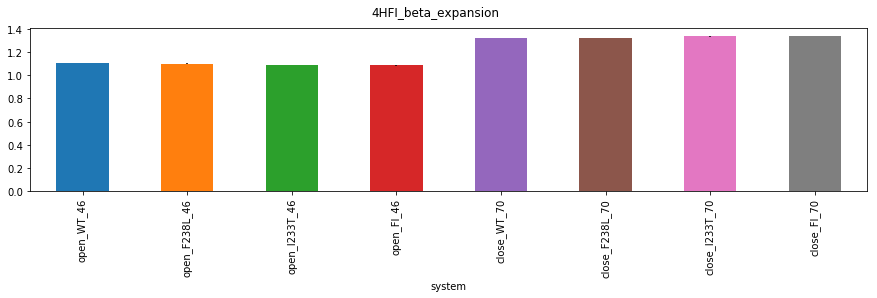

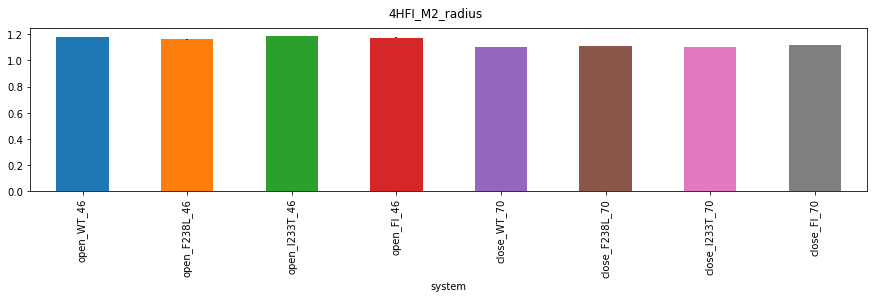

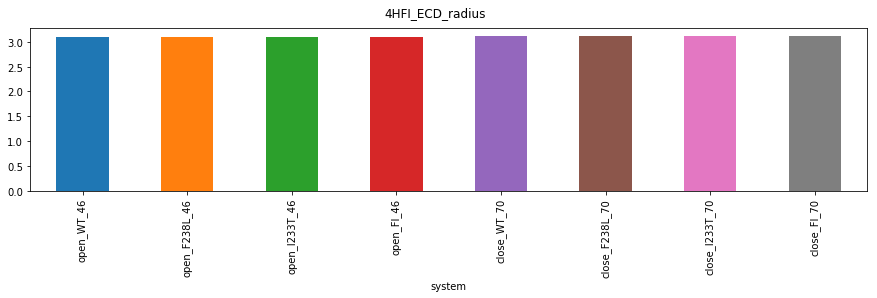

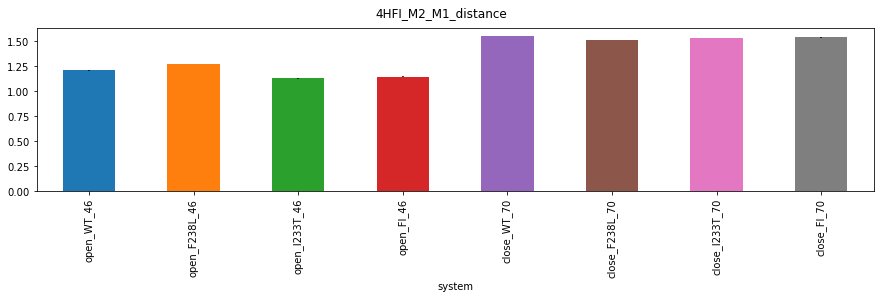

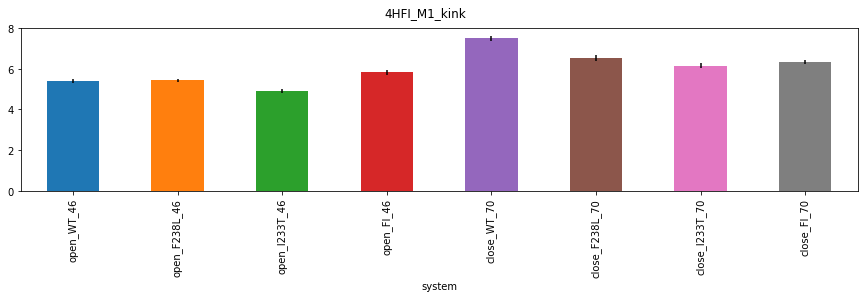

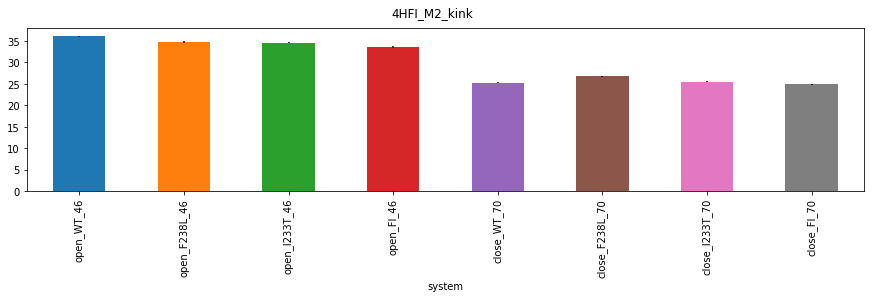

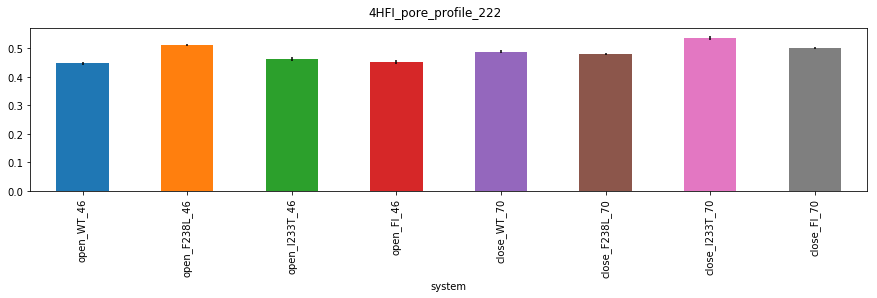

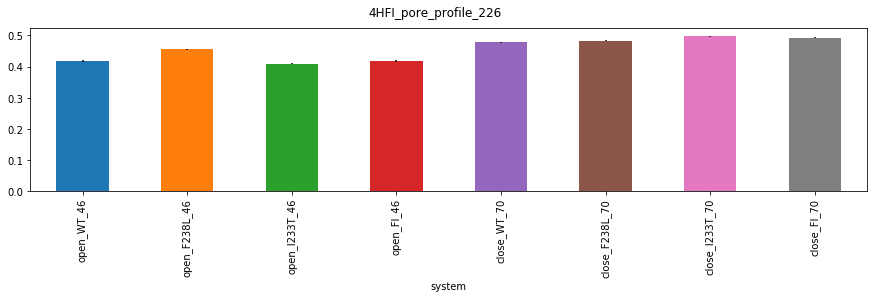

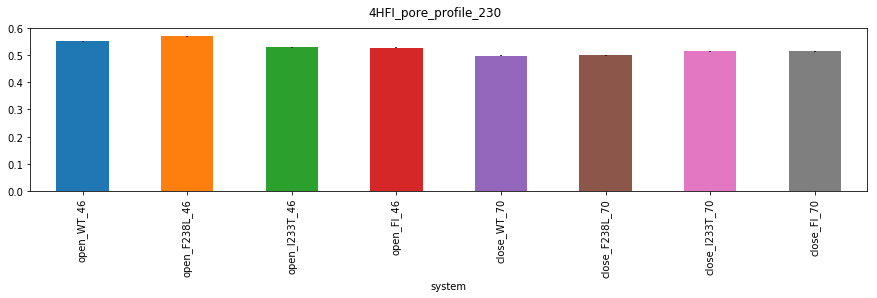

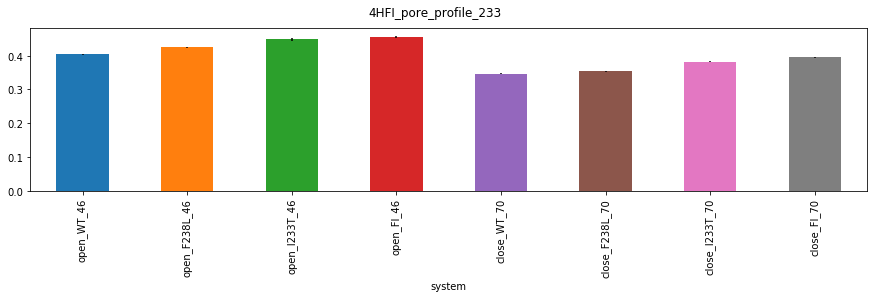

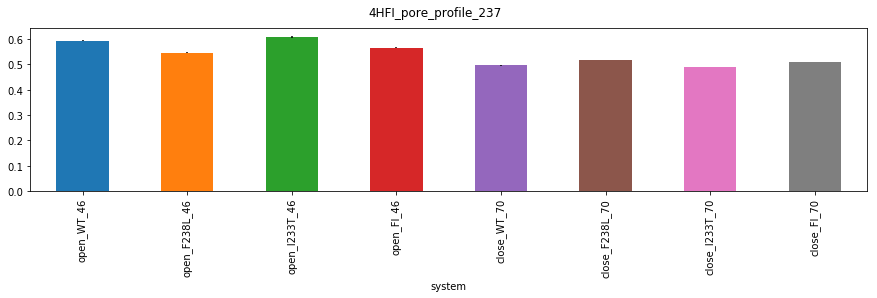

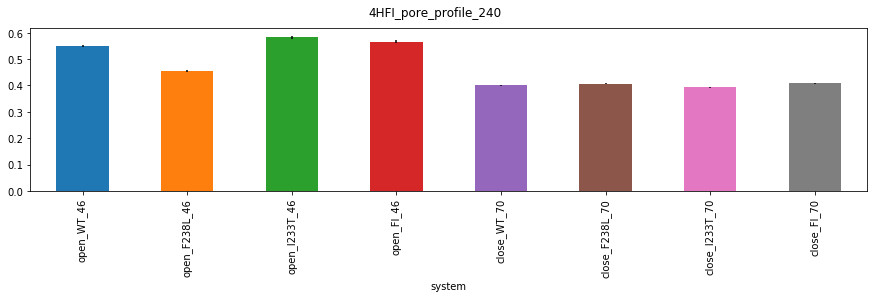

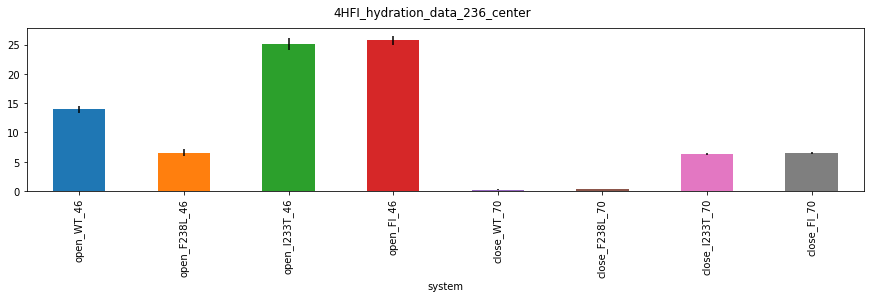

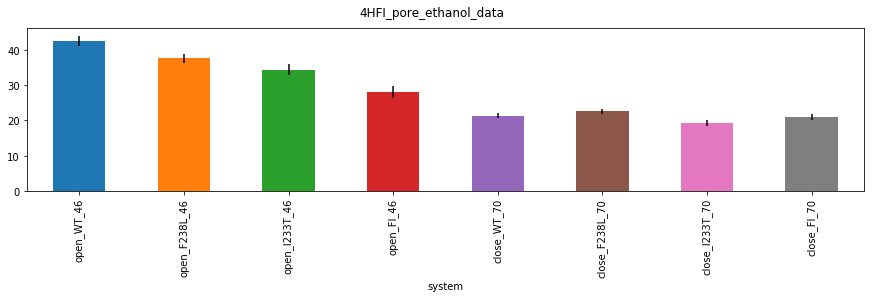

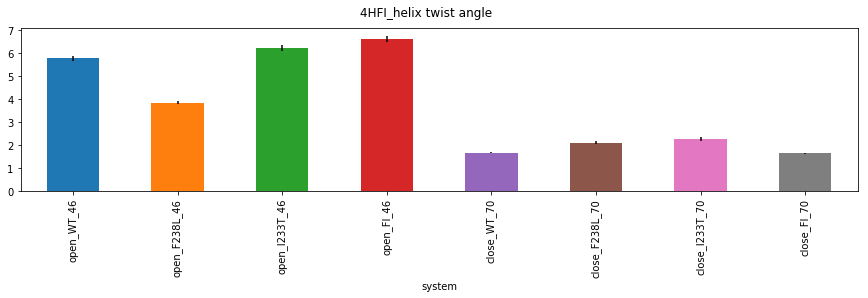

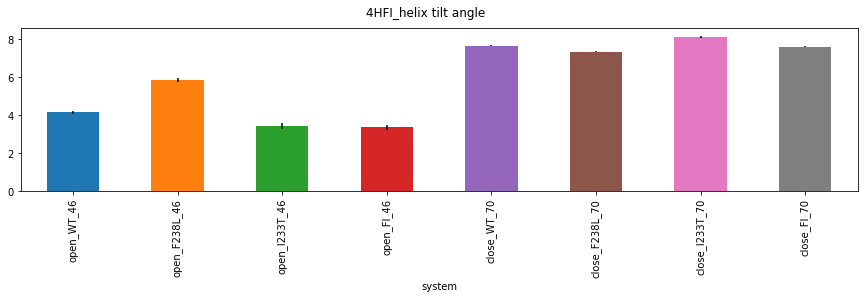

In [78]:
for feature in md_data_ethanol.columns[11:]:
#    if md_data_235[md_data_235.system == 0][feature].mean() > 2 or md_data_235[md_data_235.system == 1][feature].mean() > 2:
    fig, ax = plt.subplots(figsize=(15, 3))
#        md_data_235[md_data_235.replicate == '4'].plot(x='traj_time',y=feature,ax=ax[0],label='4',c='blue')
#        md_data_235[md_data_235.replicate == '5'].plot(x='traj_time',y=feature,ax=ax[0],label='5',c='blue')
#        md_data_235[md_data_235.replicate == '6'].plot(x='traj_time',y=feature,ax=ax[0],label='6',c='blue')
#        md_data_235[md_data_235.replicate == '7'].plot(x='traj_time',y=feature,ax=ax[0],label='7',c='red')
#        md_data_235[md_data_235.replicate == '8'].plot(x='traj_time',y=feature,ax=ax[0],label='8',c='red')
#        md_data_235[md_data_235.replicate == '9'].plot(x='traj_time',y=feature,ax=ax[0],label='9',c='red')
#        ax[0].set_xlim(0,90)
    fig.suptitle('4HFI_' + feature)
    group = md_data_ethanol[(md_data_ethanol.system.isin([0,1,3,4,9,10,11,12]))].groupby(['system'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
    ax.set_xticklabels(['open_WT_46','open_F238L_46','open_I233T_46','open_FI_46','close_WT_70','close_F238L_70','close_I233T_70','close_FI_70'])


In [77]:
def create_hydration_profile_resid(md_data = None):
    def append_hydration_data(traj_note,resid, location = default_location, skip = default_skip):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 3 -3 resid " + str(resid) + ") and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    for resid in [235,233,238,226,240]:
        hydration_data = []
        for traj_note in traj_notes:
            append_hydration_data(traj_note,resid)
        md_data['hydration_data' + str(resid) + '_3a'] = hydration_data

In [78]:
def create_hydration_profile_non_pore(md_data = None):
    def append_hydration_data(traj_note, location = default_location, skip = default_skip):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_m123'] = hydration_data

In [79]:
def create_hydration_profile_non_pore(md_data = None):
    def append_hydration_data(traj_note, location = default_location, skip = default_skip):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and resname HOH and ((type O))",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_non_pore'] = hydration_data

In [80]:
# Not accurate

In [81]:
def create_hydration_profile_non_pore_inter(md_data = None):
    def append_hydration_data(traj_note, location = default_location, skip = default_skip):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(((cyzone 10 10 -10 resnum 230) and (cyzone 10 10 -10 resnum 541)) or ((cyzone 10 10 -10 resnum 541) and (cyzone 10 10 -10 resnum 852)) or ((cyzone 10 10 -10 resnum 852) and (cyzone 10 10 -10 resnum 1163)) or((cyzone 10 10 -10 resnum 1163) and (cyzone 10 10 -10 resnum 1474)) or((cyzone 10 10 -10 resnum 1474) and (cyzone 10 10 -10 resnum 230))) and (cylayer 7 20 8 -8 resid 235) and resname HOH and ((type O))",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_inter_new'] = hydration_data

In [82]:
def create_hydration_profile_non_pore_intra(md_data = None):
    def append_hydration_data(traj_note, location = default_location, skip = default_skip):
        top_location = traj_note + '/' + traj_note + ".system.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(not (((cyzone 10 10 -10 resnum 230) and (cyzone 10 10 -10 resnum 541)) or ((cyzone 10 10 -10 resnum 541) and (cyzone 10 10 -10 resnum 852)) or ((cyzone 10 10 -10 resnum 852) and (cyzone 10 10 -10 resnum 1163)) or ((cyzone 10 10 -10 resnum 1163) and (cyzone 10 10 -10 resnum 1474)) or ((cyzone 10 10 -10 resnum 1474) and (cyzone 10 10 -10 resnum 230)))) and (cylayer 7 20 8 -8 resid 235) and resname HOH and ((type O))",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_intra_new'] = hydration_data

### Step 6
preprocess: run **hbond_tmd.py**

In [7]:
def create_hond_analysis_folder(traj_note, location = default_location, skip = default_skip):   
    import os, sys
    path = location + traj_note + '/hbond_analysis'
    os.mkdir(path)
for traj_note in traj_notes:
    try:
        create_hond_analysis_folder(traj_note)
    except FileExistsError:
        print('exit')

exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit


In [83]:
def create_Hbond_data(traj_note, location = default_location, skip = default_skip):
    hbond_data = pd.read_csv(location + traj_note + '/hbond_tmd.csv')
    water_bridge_data = pd.read_csv(location + traj_note + '/water_bridge_tmd.csv')
    top_location = traj_note + '/' + traj_note + ".system.pdb"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
    traj = md.load(location + traj_location,top = location + top_location)
    topology = traj.topology
    table, bonds = topology.to_dataframe()
    n_frames = traj.n_frames
    for resid in range(198,315):
        hbond_dataframe = pd.DataFrame(columns=list(['traj_time','resid','counterpart']))
        water_bridge_dataframe = pd.DataFrame(columns=list(['traj_time','resid','counterpart']))   
        for time in range(0,n_frames*10000,10000):  
            
            # Gather acceptor_list donor_list data
            
            hbond_donor = hbond_data[(hbond_data['time'] == time ) & (hbond_data['donor_resid'] == resid)]
            n_donor_hbond = len(hbond_donor)
            acceptor_list = []
            for donor_ind in sorted(set(hbond_donor['donor_index'])):
                acceptor_list.append([donor_ind,hbond_donor[hbond_donor['donor_index'] == donor_ind].iloc[:,3:4].values.T.tolist()[0]])
                
            hbond_acceptor = hbond_data[(hbond_data['time'] == time) & (hbond_data['acceptor_resid'] == resid)]
            n_acceptor_hbond = len(hbond_acceptor)
            donor_list = []
            for acceptor_ind in sorted(set(hbond_acceptor['acceptor_index'])):
                donor_list.append([acceptor_ind,hbond_acceptor[hbond_acceptor['acceptor_index'] == acceptor_ind].iloc[:,2:3].values.T.tolist()[0]])
                
            for hbond_pair in donor_list + acceptor_list:
                if (table.loc[hbond_pair[0]].resName != 'HOH') & (table.loc[hbond_pair[0]].resName != 'CL') & (table.loc[hbond_pair[0]].resName != 'NA') & (table.loc[hbond_pair[0]].resName != 'POP'):
                    hbond_counterparts = []
                    for hbond_counterpart in hbond_pair[1]:
                        if (table.loc[hbond_counterpart].resName != 'HOH') & (table.loc[hbond_counterpart].resName != 'CL') & (table.loc[hbond_counterpart].resName != 'NA') & (table.loc[hbond_counterpart].resName != 'POP'):
                            hbond_counterparts.append(hbond_counterpart)
                    hbond_dataframe = hbond_dataframe.append({'traj_time':time,'resid': hbond_pair[0], 'counterpart': hbond_counterparts},ignore_index=True)
                
            # Analyze percentage
           
            water_bridge_donor = water_bridge_data[(water_bridge_data['time'] == time) & (water_bridge_data['donor_resid'] == resid)]
            acceptor_list = []
            if not(water_bridge_donor.empty):
                for donor_ind in sorted(set(water_bridge_donor['donor_index'])):
                    for water_resid in set(water_bridge_donor[water_bridge_donor['donor_index'] == donor_ind]['acceptor_resid']):
                        acceptor_list.append([donor_ind,water_bridge_data[(water_bridge_data['time'] == time) & (water_bridge_data['acceptor_resid'] == water_resid) & (water_bridge_data['donor_resid'] != resid)].iloc[:,2:3].values.flatten().tolist()])
                        acceptor_list.append([donor_ind,water_bridge_data[(water_bridge_data['time'] == time) & (water_bridge_data['donor_resid'] == water_resid) & (water_bridge_data['donor_resid'] != resid)].iloc[:,3:4].values.flatten().tolist()])
            water_bridge_acceptor = water_bridge_data[(water_bridge_data['time'] == time) & (water_bridge_data['acceptor_resid'] == resid)]
            donor_list = []
            if not(water_bridge_acceptor.empty):
                for acceptor_ind in sorted(set(water_bridge_donor['acceptor_index'])):
                    for water_resid in set(water_bridge_donor[water_bridge_donor['acceptor_index'] == acceptor_ind]['donor_resid']):
                        donor_list.append([donor_ind,water_bridge_data[(water_bridge_data['time'] == time) & (water_bridge_data['acceptor_resid'] == water_resid) & (water_bridge_data['acceptor_resid'] != resid)].iloc[:,2:3].values.flatten().tolist()])
                        donor_list.append([donor_ind,water_bridge_data[(water_bridge_data['time'] == time) & (water_bridge_data['donor_resid'] == water_resid) & (water_bridge_data['acceptor_resid'] != resid)].iloc[:,3:4].values.flatten().tolist()])
            for w_bridge_pair in acceptor_list + donor_list:
                if (table.loc[w_bridge_pair[0]].resName != 'HOH') & (table.loc[w_bridge_pair[0]].resName != 'CL') & (table.loc[w_bridge_pair[0]].resName != 'NA') & (table.loc[w_bridge_pair[0]].resName != 'POP'):
                    if w_bridge_pair[1] == []:
                        water_bridge_dataframe = water_bridge_dataframe.append({'traj_time':time,'resid': w_bridge_pair[0], 'counterpart': [w_bridge_pair[0]]},ignore_index=True)
                    else:
                        water_bridgecounterparts = []
                        for water_bridge_counterpart in w_bridge_pair[1]:
                            if (table.loc[water_bridge_counterpart].resName != 'HOH') & (table.loc[water_bridge_counterpart].resName != 'CL') & (table.loc[water_bridge_counterpart].resName != 'NA') & (table.loc[water_bridge_counterpart].resName != 'POP'):
                                water_bridgecounterparts.append(water_bridge_counterpart)
                            water_bridge_dataframe = water_bridge_dataframe.append({'traj_time':time,'resid': w_bridge_pair[0], 'counterpart': water_bridgecounterparts},ignore_index=True)


        hbond_dataframe.to_csv(location + traj_note + '/hbond_analysis/' + str(resid) + '_hbond_list.csv' )
        water_bridge_dataframe.to_csv(location + traj_note + '/hbond_analysis/' + str(resid) + '_water_bridge_list.csv')
    print('finishing!')
   #         print('At time ' + str(time) + ', in total ' + str(n_hbond) + ' hydrogen bonds between residues, resid '
   #               + str(resid) + ' forms ' + str(n_intra_hbond) + ' intra-subunit H-bond and ' + str(n_inter_hbond) + ' inter-subunit H-bond.')

In [127]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(create_Hbond_data)(traj_note) for traj_note in traj_notes)

finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!
finishing!


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
md_data_FL =pd.read_pickle('glic_activation_FL_235.pickle')

### Step 7

In [123]:
resid_pair_hbond_dataframe = pd.DataFrame(columns=list(['traj_note','traj_time','resid1','resid2','inter_hbond','intra_hbond','inter_water_bridge','intra_water_bridge']))

In [124]:
resid_pair_hbond_dataframe.to_pickle('pair_hbond_4HFI_2H.pickle')

In [125]:
def append_resid_pair_hbond_data(traj_note, location = default_location, skip = default_skip):
    top_location = traj_note + '/' + traj_note + ".system.pdb"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
    traj = md.load(location + traj_location,top = location + top_location)
    topology = traj.topology
    table, bonds = topology.to_dataframe()
    n_frames = traj.n_frames
    resid_pair_hbond_dataframe = pd.DataFrame(columns=list(['traj_note','traj_time','resid1','resid2','inter_hbond','intra_hbond','inter_water_bridge','intra_water_bridge']))
#        resid_pair_hbond_dataframe = pd.read_pickle('pair_hbond.pickle')
    for resid1 in np.arange(198,315):
        hbond_dataframe = pd.read_csv(location + traj_note + '/hbond_analysis/' + str(resid1) + '_hbond_list.csv')
        import ast
        hbond_dataframe['counterpart'] = hbond_dataframe['counterpart'].apply(lambda x: ast.literal_eval(x))
        water_bridge_dataframe = pd.read_csv(location + traj_note + '/hbond_analysis/' + str(resid1) + '_water_bridge_list.csv')
        water_bridge_dataframe['counterpart'] = water_bridge_dataframe['counterpart'].apply(lambda x: ast.literal_eval(x))

        for time in range(0,n_frames*10000,10000): 


            for residue_id in set(hbond_dataframe['resid']):

                counterpart_residue = hbond_dataframe[(hbond_dataframe['resid'] == residue_id) & (hbond_dataframe['traj_time'] == time)]['counterpart']
                for counterpart_residue_list in counterpart_residue:
                    for counterpart_residue_id in counterpart_residue_list:
                        if table.loc[counterpart_residue_id].chainID != table.loc[residue_id].chainID:
                            resid_pair_hbond_dataframe = resid_pair_hbond_dataframe.append({'traj_note': traj_note, 'traj_time': time/10000,'resid1': resid1, 'resid2':table.loc[counterpart_residue_id].resSeq, 'inter_hbond': table.loc[counterpart_residue_id].resSeq},ignore_index=True)

                        else:
                            resid_pair_hbond_dataframe = resid_pair_hbond_dataframe.append({'traj_note': traj_note, 'traj_time': time/10000,'resid1': resid1, 'resid2':table.loc[counterpart_residue_id].resSeq, 'intra_hbond': table.loc[counterpart_residue_id].resSeq},ignore_index=True)


            for residue_id in set(water_bridge_dataframe['resid']):
                counterpart_residue = water_bridge_dataframe[(water_bridge_dataframe['resid'] == residue_id) & (water_bridge_dataframe['traj_time'] == time)]['counterpart'].values
                for counterpart_residue_list in counterpart_residue:
                    for counterpart_residue_id in counterpart_residue_list:
                        if table.loc[counterpart_residue_id].chainID != table.loc[residue_id].chainID:
                            resid_pair_hbond_dataframe = resid_pair_hbond_dataframe.append({'traj_note': traj_note, 'traj_time': time/10000,'resid1': resid1, 'resid2':table.loc[counterpart_residue_id].resSeq, 'inter_water_bridge': table.loc[counterpart_residue_id].resSeq},ignore_index=True)
                            resid_pair_hbond_dataframe = resid_pair_hbond_dataframe.append({'traj_note': traj_note, 'traj_time': time/10000,'resid1': table.loc[counterpart_residue_id].resSeq, 'resid2':resid1, 'inter_water_bridge': resid1},ignore_index=True)

                        else:
                            resid_pair_hbond_dataframe = resid_pair_hbond_dataframe.append({'traj_note': traj_note, 'traj_time': time/10000,'resid1': resid1, 'resid2':table.loc[counterpart_residue_id].resSeq, 'intra_water_bridge': table.loc[counterpart_residue_id].resSeq},ignore_index=True)
                            resid_pair_hbond_dataframe = resid_pair_hbond_dataframe.append({'traj_note': traj_note, 'traj_time': time/10000,'resid1': table.loc[counterpart_residue_id].resSeq, 'resid2':resid1, 'intra_water_bridge': resid1},ignore_index=True)

    resid_pair_hbond_dataframe.to_pickle('hbond_pair/' + traj_note + '_pair_hbond.pickle')


In [ ]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(append_resid_pair_hbond_data)(traj_note) for traj_note in traj_notes)

In [106]:
pair_hbond = pd.DataFrame()
for traj_note in traj_notes:
    pair_hbond = pair_hbond.append(pd.read_pickle('hbond_pair/' + traj_note + '_pair_hbond.pickle'))
pair_hbond.to_pickle('pair_hbond_4HFI_2H_all.pickle')

In [46]:
md_data = pd.read_pickle('glic_activation_open_235.pickle')

In [107]:
def create_hbond_data(resid1,resid2,hbond_type,md_data):
    interaction_list = []
    interaction_df = pair_hbond[(pair_hbond.resid1 == resid1) & (pair_hbond.resid2 == resid2) & (pair_hbond[hbond_type] > 0 )]
    for traj_note in traj_notes:
        location = default_location
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip10.ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        n_frames = traj.n_frames
        for traj_time in range(0,n_frames):
            interaction_list.append(interaction_df[(interaction_df.traj_note == traj_note) & (interaction_df.traj_time == traj_time)].shape[0])
    md_data[hbond_type + '_' + str(resid1) + '_' + str(resid2)] = interaction_list

In [108]:
create_hbond_data(200,239,'inter_water_bridge',md_data_235)

In [109]:
create_hbond_data(200,243,'inter_water_bridge',md_data_235)

In [110]:
create_hbond_data(200,263,'inter_water_bridge',md_data_235)

In [111]:
create_hbond_data(200,243,'inter_hbond',md_data_235)

In [112]:
create_hbond_data(200,239,'inter_hbond',md_data_235)

In [113]:
create_hbond_data(200,234,'intra_hbond',md_data_235)

In [114]:
create_hbond_data(205,235,'intra_hbond',md_data_235)

In [115]:
create_hbond_data(205,235,'intra_water_bridge',md_data_235)

In [116]:
create_hbond_data(263,243,'intra_water_bridge',md_data_235)

In [117]:
create_hbond_data(235,259,'intra_water_bridge',md_data_235)

In [118]:
create_hbond_data(235,259,'intra_hbond',md_data_235)

In [121]:
md_data_235.to_pickle('glic_activation_open_235.pickle')

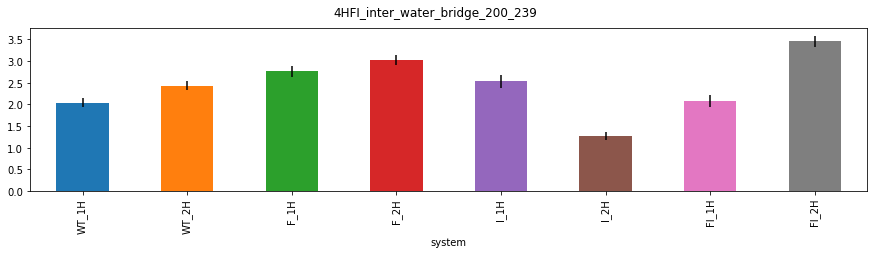

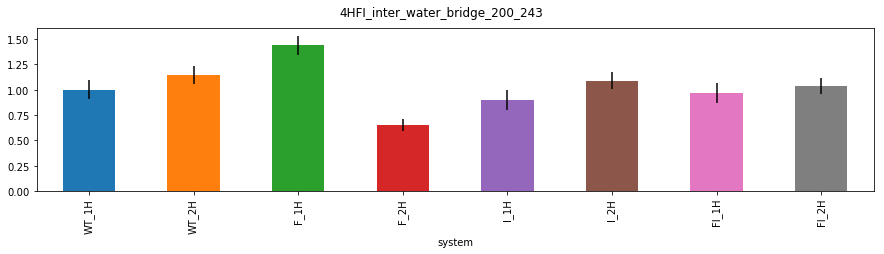

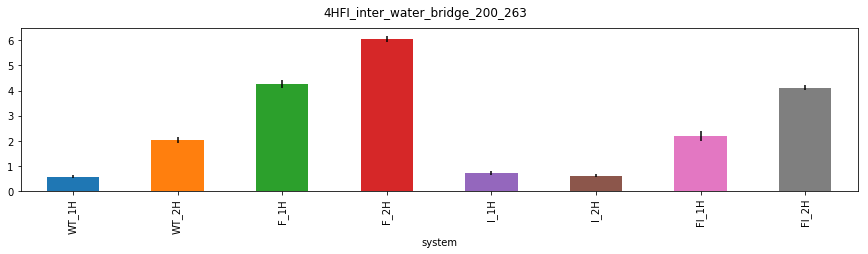

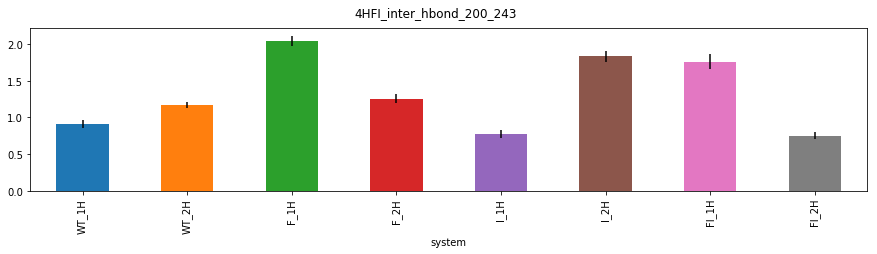

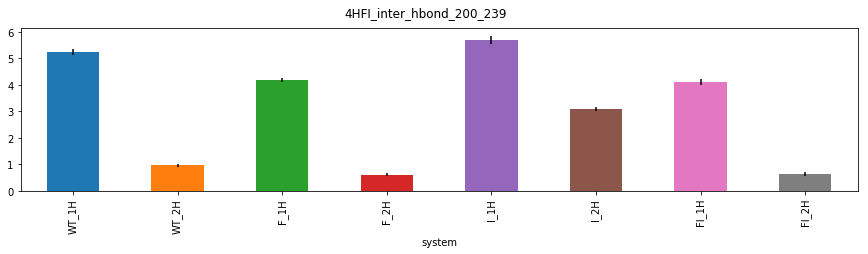

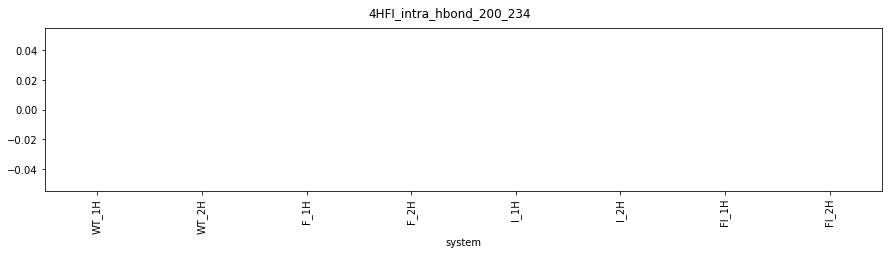

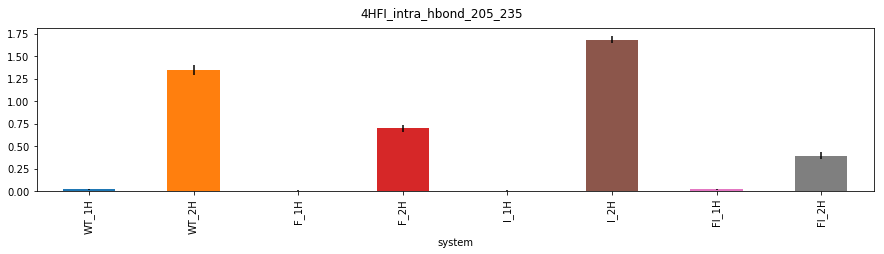

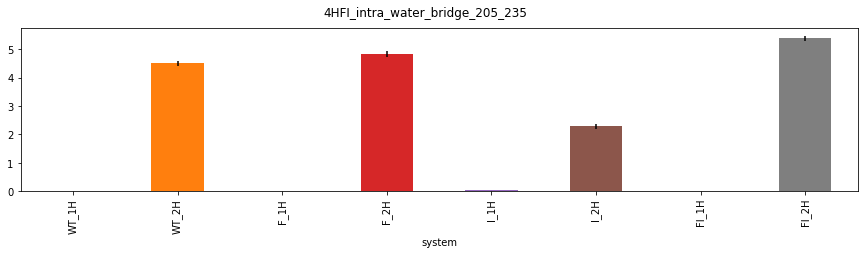

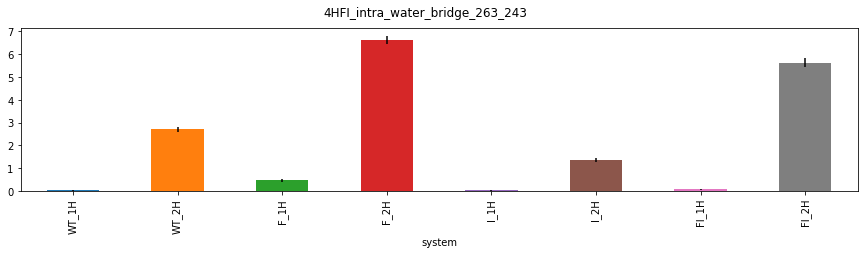

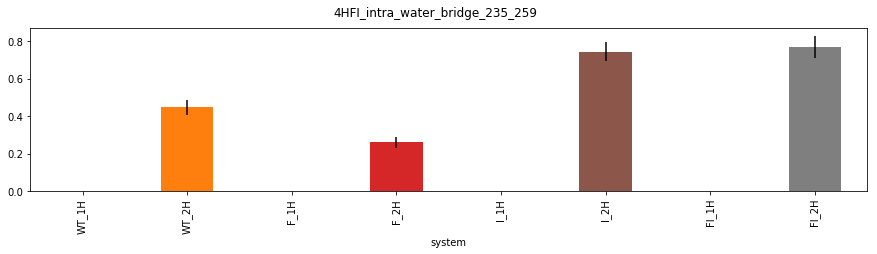

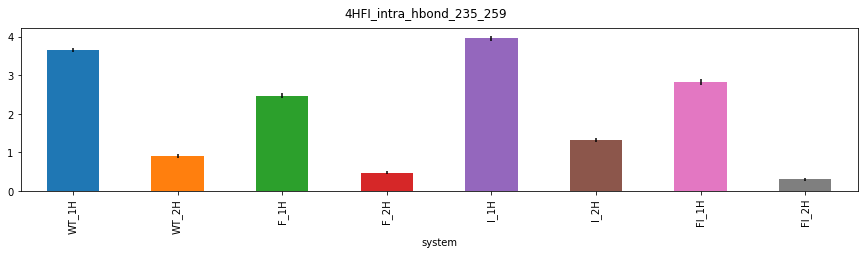

In [120]:
for feature in md_data_235.columns[31:]:
    fig, ax = plt.subplots(figsize=(15, 3))
#        md_data_235[md_data_235.replicate == '4'].plot(x='traj_time',y=feature,ax=ax[0],label='4',c='blue')
#        md_data_235[md_data_235.replicate == '5'].plot(x='traj_time',y=feature,ax=ax[0],label='5',c='blue')
#        md_data_235[md_data_235.replicate == '6'].plot(x='traj_time',y=feature,ax=ax[0],label='6',c='blue')
#        md_data_235[md_data_235.replicate == '7'].plot(x='traj_time',y=feature,ax=ax[0],label='7',c='red')
#        md_data_235[md_data_235.replicate == '8'].plot(x='traj_time',y=feature,ax=ax[0],label='8',c='red')
#        md_data_235[md_data_235.replicate == '9'].plot(x='traj_time',y=feature,ax=ax[0],label='9',c='red')
#        ax[0].set_xlim(0,90)
    fig.suptitle('4HFI_' + feature)
    group = md_data_235.groupby(['system'],sort=False)[feature]
    mean = group.mean()
    errors = group.sem()
    mean.plot.bar(yerr=errors,ax=ax)
    ax.set_xticklabels(['WT_1H','WT_2H','F_1H','F_2H','I_1H','I_2H','FI_1H','FI_2H'])


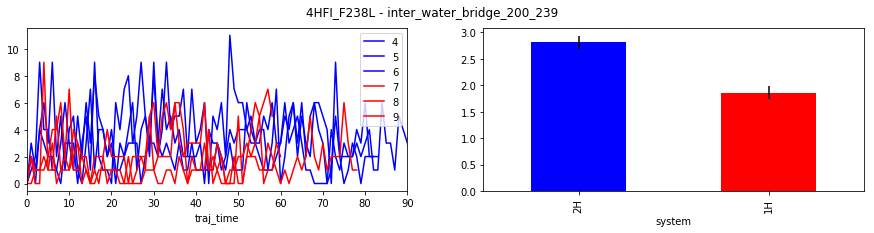

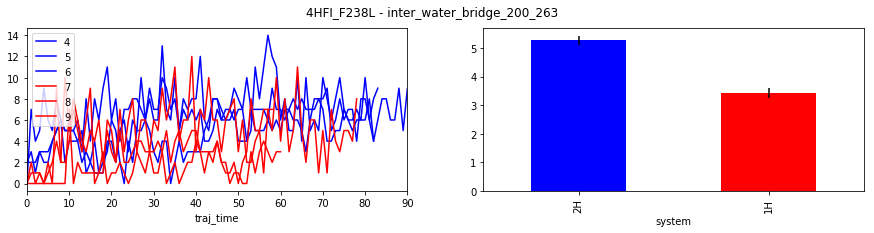

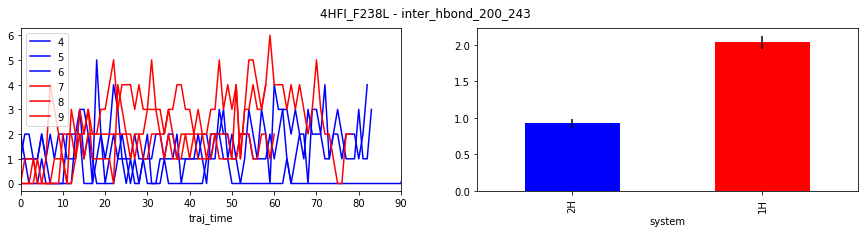

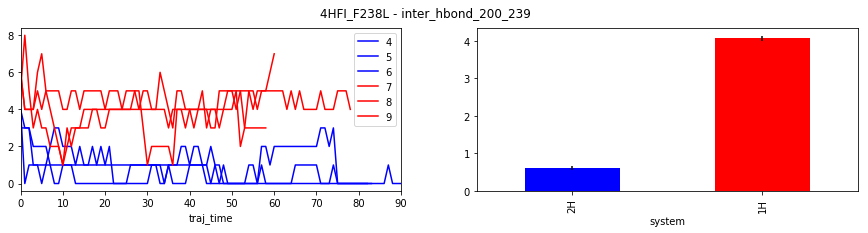

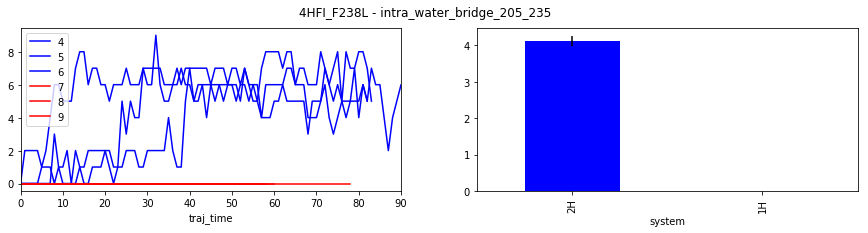

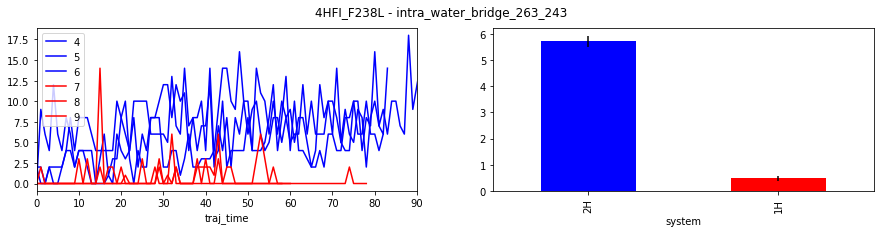

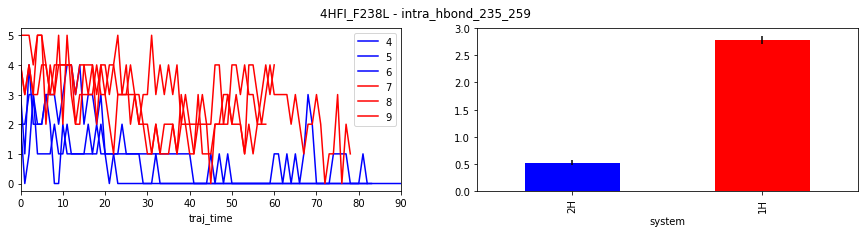

In [223]:
for feature in md_data_FL.columns[31:]:
    if md_data_FL[md_data_FL.system == 0][feature].mean() > 2 or md_data_FL[md_data_FL.system == 1][feature].mean() > 2:
        fig, ax = plt.subplots(1,2,figsize=(15, 3))
        md_data_FL[md_data_FL.replicate == '4'].plot(x='traj_time',y=feature,ax=ax[0],label='4',c='blue')
        md_data_FL[md_data_FL.replicate == '5'].plot(x='traj_time',y=feature,ax=ax[0],label='5',c='blue')
        md_data_FL[md_data_FL.replicate == '6'].plot(x='traj_time',y=feature,ax=ax[0],label='6',c='blue')
        md_data_FL[md_data_FL.replicate == '7'].plot(x='traj_time',y=feature,ax=ax[0],label='7',c='red')
        md_data_FL[md_data_FL.replicate == '8'].plot(x='traj_time',y=feature,ax=ax[0],label='8',c='red')
        md_data_FL[md_data_FL.replicate == '9'].plot(x='traj_time',y=feature,ax=ax[0],label='9',c='red')
        ax[0].set_xlim(0,90)
        fig.suptitle('4HFI_F238L - ' + feature)
        group = md_data_FL.groupby(['system'],sort=False)[feature]
        mean = group.mean()
        errors = group.sem()
        mean.plot.bar(yerr=errors,ax=ax[1],color=['blue','red'])
        ax[1].set_xticklabels(['2H','1H'])


In [10]:
def create_Hbond_network_analysis_data(traj_note, location = default_location, skip=default_skip):
    top_location = traj_note + '/' + traj_note + ".system.pdb"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
    traj = md.load(location + traj_location,top = location + top_location)
    topology = traj.topology
    table, bonds = topology.to_dataframe()
    n_frames = traj.n_frames
    zero_data = np.zeros(shape=([118*5,118*5]))
    hbond_network_dataframe = pd.DataFrame()
    for time in range(0,n_frames*10000,10000):  
        hbond_network = pd.DataFrame(zero_data,columns=np.asarray([np.arange(193,311),np.arange(193,311) + 311,np.arange(193,311) + 311 * 2,np.arange(193,311) + 311 * 3,np.arange(193,311) + 311 * 4]).flatten())
        hbond_network['traj_time'] = time/10000
        hbond_network['residue'] = np.asarray([np.arange(193,311),np.arange(193,311) + 311,np.arange(193,311) + 311 * 2,np.arange(193,311) + 311 * 3,np.arange(193,311) + 311 * 4]).flatten()
        hbond_network_dataframe = hbond_network_dataframe.append(hbond_network,ignore_index=True)
    for time in range(0,n_frames*10000,10000):  
        for resid in range(198,315):
            hbond_dataframe = pd.read_csv(location + traj_note + '/hbond_analysis/' + str(resid) + '_hbond_list.csv')
            hbond_dataframe['counterpart'] = hbond_dataframe['counterpart'].apply(lambda x: ast.literal_eval(x))
            water_bridge_dataframe = pd.read_csv(location + traj_note + '/hbond_analysis/' + str(resid) + '_water_bridge_list.csv')
            water_bridge_dataframe['counterpart'] = water_bridge_dataframe['counterpart'].apply(lambda x: ast.literal_eval(x))

            for residue_id in set(hbond_dataframe['resid']):
                counterpart_residue = hbond_dataframe[(hbond_dataframe['resid'] == residue_id) & (hbond_dataframe['traj_time'] == time)]['counterpart']
                for counterpart_residue_list in counterpart_residue:
                    for counterpart_residue_id in counterpart_residue_list:
                        if (table.loc[counterpart_residue_id].resSeq >= 198) & (table.loc[counterpart_residue_id].resSeq <= 315) & (table.loc[residue_id].resSeq >= 198) & (table.loc[residue_id].resSeq <= 315):
                            residue1 = table.loc[residue_id].resSeq + (table.loc[residue_id].chainID) * 311 - 5
                            residue2 = table.loc[counterpart_residue_id].resSeq + (table.loc[counterpart_residue_id].chainID) * 311 - 5

                            hbond_network_dataframe.loc[(hbond_network_dataframe.traj_time == time/10000) & (hbond_network_dataframe.residue == residue1),residue2] = 1
                            hbond_network_dataframe.loc[(hbond_network_dataframe.traj_time == time/10000) & (hbond_network_dataframe.residue == residue2),residue1] = 1

            for residue_id in set(water_bridge_dataframe['resid']):
                counterpart_residue = water_bridge_dataframe[(water_bridge_dataframe['resid'] == residue_id) & (water_bridge_dataframe['traj_time'] == time)]['counterpart'].values
                for counterpart_residue_list in counterpart_residue:
                    for counterpart_residue_id in counterpart_residue_list:
                        if (table.loc[counterpart_residue_id].resSeq >= 198) & (table.loc[counterpart_residue_id].resSeq <= 315) & (table.loc[residue_id].resSeq >= 198) & (table.loc[residue_id].resSeq <= 315):
                            residue1 = table.loc[residue_id].resSeq + (table.loc[residue_id].chainID) * 311 - 5
                            residue2 = table.loc[counterpart_residue_id].resSeq + (table.loc[counterpart_residue_id].chainID) * 311 - 5
                            hbond_network_dataframe.loc[(hbond_network_dataframe.traj_time == time /10000) & (hbond_network_dataframe.residue == residue1),residue2] = 1
                            hbond_network_dataframe.loc[(hbond_network_dataframe.traj_time == time /10000) & (hbond_network_dataframe.residue == residue2),residue1] = 1

    hbond_network_dataframe.to_csv(location + traj_note + '/hbond_analysis/hbond_network.csv')
    print('finishing!')
   #         print('At time ' + str(time) + ', in total ' + str(n_hbond) + ' hydrogen bonds between residues, resid '
   #               + str(resid) + ' forms ' + str(n_intra_hbond) + ' intra-subunit H-bond and ' + str(n_inter_hbond) + ' inter-subunit H-bond.')

In [11]:
def create_hbond_contact_map(traj_note, location = default_location, skip=default_skip):
    top_location = traj_note + '/' + traj_note + ".ca.pdb"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
    traj = md.load(location + traj_location,top = location + top_location)
    n_frames = traj.n_frames
    hbond_contact_map = pd.DataFrame(columns=['residue1','residue2','interaction'])
    hbond_network_dataframe = pd.read_csv(location + traj_note + '/hbond_analysis/hbond_network.csv')
    for column in hbond_network_dataframe.columns:
        if (column !=  'traj_time') & (column != 'residue') & (column != 'Unnamed: 0'):
            residue1s = hbond_network_dataframe.loc[(hbond_network_dataframe[column] != 0)]['residue'].values
            residue2 = int(column)
            for residue1 in set(residue1s):
                if hbond_contact_map[(hbond_contact_map.residue1 == residue1) & (hbond_contact_map.residue2 == residue2)].empty:
                    interaction_sum = hbond_network_dataframe[(hbond_network_dataframe[column] != 0) & (hbond_network_dataframe.residue == residue1)].shape[0]
                    hbond_contact_map = pd.concat([hbond_contact_map,pd.DataFrame([[residue1,residue2,interaction_sum / n_frames]],columns=['residue1','residue2','interaction'])],ignore_index=True)
                else:
                    interaction_sum = hbond_network_dataframe[(hbond_network_dataframe[column] != 0) & (hbond_network_dataframe.residue == residue1)].shape[0]
                    hbond_contact_map.loc[(hbond_contact_map.residue1 == residue1) & (hbond_contact_map.residue2 == residue2),'interaction'] += interaction_sum / n_frames
    #print(hbond_contact_map)
    hbond_contact_map.to_csv(location + traj_note + '/hbond_analysis/hbond_contact_map.csv')
    print('finishing! ' + traj_note)

In [12]:
trans_ind = np.asarray([np.arange(193,311),np.arange(504,622),np.arange(815,933),np.arange(1126,1244),np.arange(1437,1555)]).flatten()

In [13]:
def transform_hbond_network_data(traj_note):
    hbond_data = pd.read_csv(default_location + traj_note + '/hbond_analysis/hbond_contact_map.csv')
    hbond_data_all = pd.DataFrame(columns=['residue1','residue2','hbond'])
    for ind in trans_ind:
        hbond_data_all = hbond_data_all.append(pd.DataFrame(np.concatenate(([np.zeros([590]) + ind], [trans_ind],[np.zeros([590])]), axis=0).T,columns=['residue1','residue2','hbond']),ignore_index=True)
    for residue1,residue2 in hbond_data[['residue1','residue2']].values:
        hbond_data_all.loc[(hbond_data_all.residue1 == residue1) & (hbond_data_all.residue2 == residue2),'hbond'] = hbond_data[(hbond_data.residue1 == residue1) & (hbond_data.residue2 == residue2)]['interaction'].values 
    hbond_data_all.to_csv(default_location + traj_note + '/hbond_analysis/hbond_contact_map_complete.csv')
#    hbond_data_trans.append(hbond_data_all['hbond'].values.reshape([590,590]))
#    hbond_data_mean = np.mean(hbond_data_trans,axis=0)
#    np.savetxt(default_location + traj_notes[0] + '/hbond_analysis/' + traj_notes[0][:-4] + '_hbond_network_data_transmembrane_mean.dat',hbond_data_mean)        

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(create_Hbond_network_analysis_data)(traj_note) for traj_note in traj_notes)
Parallel(n_jobs=num_cores)(delayed(create_hbond_contact_map)(traj_note) for traj_note in traj_notes)
Parallel(n_jobs=num_cores)(delayed(transform_hbond_network_data)(traj_note) for traj_note in traj_notes)


In [20]:
def gather_replicates(traj_notes,location = default_location):
    pearson_avg = []
    for traj_note in traj_notes:
        contact_map = pd.read_csv(location + traj_note + '/hbond_analysis/hbond_contact_map_complete.csv')
        pearson_avg.append(contact_map['hbond'].values)
    contact_map['hbond'] = np.mean(pearson_avg,axis=0)
    return contact_map

In [21]:
def plot_hbond_map(data,ax,note):
    data[data.hbond >= 0.5].plot(kind='scatter',x='residue1',y='residue2',c='hbond',colormap='autumn',ax=ax)
    ax.set_title(note + ' Hbond & Water Bridge Map (lifetime > 0.5)')
    plt.show()

In [22]:
def plot_intra_hbond_map(data,note,ax):
    data1 = data[(data.residue1 <= 311) & (data.residue2 <= 311)]
    data2 = data[(data.residue1 > 311) & (data.residue1 <= 311 *2) &(data.residue2 > 311) & (data.residue2 <= 311 *2)]
    data3 = data[(data.residue1 > 311 *2) & (data.residue1 <= 311 *3) &(data.residue2 > 311 *2) & (data.residue2 <= 311 *3)]
    data4 = data[(data.residue1 > 311 *3) & (data.residue1 <= 311 *4) &(data.residue2 > 311 *3) & (data.residue2 <= 311 *4)]
    data5 = data[(data.residue1 > 311 *4) & (data.residue1 <= 311 *5) &(data.residue2 > 311 *4) & (data.residue2 <= 311 *5)]
    data2.residue1 = data1.residue1.values
    data2.residue2 = data1.residue2.values
    data3.residue1 = data1.residue1.values
    data3.residue2 = data1.residue2.values   
    data4.residue1 = data1.residue1.values
    data4.residue2 = data1.residue2.values   
    data5.residue1 = data1.residue1.values
    data5.residue2 = data1.residue2.values   
    data1 = data1[data1['hbond'] >= 0.1].reset_index()
    data2 = data2[data2['hbond'] >= 0.1].reset_index()
    data3 = data3[data3['hbond'] >= 0.1].reset_index()
    data4 = data4[data4['hbond'] >= 0.1].reset_index()
    data5 = data5[data5['hbond'] >= 0.1].reset_index()
    data_intra = pd.DataFrame(columns=['residue1','residue2','hbond'])
    for pair in np.array(list(set([tuple(t) for t in pd.concat([data1,data2,data3,data4,data5])[['residue1','residue2']].values]))):
        data_intra = pd.concat([data_intra,pd.DataFrame([[int(pair[0]) + 5,int(pair[1]) + 5,
#                           np.mean([data1[(data1.residue1 == pair[0]) & (data1.residue2 == pair[1])]['hbond'].values,
#                                   data2[(data2.residue1 == pair[0]) & (data2.residue2 == pair[1])]['hbond'].values,
#                                   data3[(data3.residue1 == pair[0]) & (data3.residue2 == pair[1])]['hbond'].values,
#                                   data4[(data4.residue1 == pair[0]) & (data4.residue2 == pair[1])]['hbond'].values,
#                                   data5[(data5.residue1 == pair[0]) & (data5.residue2 == pair[1])]['hbond'].values])]],
                            np.sum(np.sum([data1.loc[(data1.residue1 == pair[0]) & (data1.residue2 == pair[1]),'hbond'].values.tolist(),
                                                                data2.loc[(data2.residue1 == pair[0]) & (data2.residue2 == pair[1]),'hbond'].values.tolist(),
                                                                data3.loc[(data3.residue1 == pair[0]) & (data3.residue2 == pair[1]),'hbond'].values.tolist(),
                                                                data4.loc[(data4.residue1 == pair[0]) & (data4.residue2 == pair[1]),'hbond'].values.tolist(),
                                                                data5.loc[(data5.residue1 == pair[0]) & (data5.residue2 == pair[1]),'hbond'].values.tolist()]))/5]], 
                                                          columns=['residue1','residue2','hbond']
                                  )],ignore_index=True)
    data_intra = data_intra.convert_objects(convert_numeric=True)
    data_intra.plot(kind='scatter',x='residue1',y='residue2',c=data_intra.hbond,colormap='Greens',ax=ax,colorbar=False,vmax=1,vmin=0)
    ax.set_xlim(198,315)
    ax.set_ylim(198,315)
    data_intra.to_csv(note + '_intra_hbond.csv')

In [23]:
def plot_inter_hbond_map(data,note,ax):
    data1 = data[(data.residue1 > 311 * 0) & (data.residue1 <= 311 * 1) &(data.residue2 > 311 * 1) & (data.residue2 <= 311 *2)]
    data2 = data[(data.residue1 > 311 * 1) & (data.residue1 <= 311 * 2) &(data.residue2 > 311 * 2) & (data.residue2 <= 311 *3)]
    data3 = data[(data.residue1 > 311 * 2) & (data.residue1 <= 311 * 3) &(data.residue2 > 311 * 3) & (data.residue2 <= 311 *4)]
    data4 = data[(data.residue1 > 311 * 3) & (data.residue1 <= 311 * 4) &(data.residue2 > 311 * 4) & (data.residue2 <= 311 *5)]
    data5 = data[(data.residue1 > 311 * 4) & (data.residue1 <= 311 * 5) &(data.residue2 > 311 * 0) & (data.residue2 <= 311 * 1)]
    data2.residue1 = data1.residue1.values
    data2.residue2 = data1.residue2.values
    data3.residue1 = data1.residue1.values
    data3.residue2 = data1.residue2.values   
    data4.residue1 = data1.residue1.values
    data4.residue2 = data1.residue2.values   
    data5.residue1 = data1.residue1.values
    data5.residue2 = data1.residue2.values   
    data1 = data1[data1['hbond'] >= 0.1].reset_index()
    data2 = data2[data2['hbond'] >= 0.1].reset_index()
    data3 = data3[data3['hbond'] >= 0.1].reset_index()
    data4 = data4[data4['hbond'] >= 0.1].reset_index()
    data5 = data5[data5['hbond'] >= 0.1].reset_index()
    data_inter = pd.DataFrame(columns=['residue1','residue2','hbond'])
    for pair in np.array(list(set([tuple(t) for t in pd.concat([data1,data2,data3,data4,data5])[['residue1','residue2']].values]))):
                            
        data_inter = pd.concat([data_inter,pd.DataFrame([[int(pair[0]) + 5,int(pair[1]-311) + 5,
                                                        np.sum(np.sum([data1.loc[(data1.residue1 == pair[0]) & (data1.residue2 == pair[1]),'hbond'].values.tolist(),
                                                                data2.loc[(data2.residue1 == pair[0]) & (data2.residue2 == pair[1]),'hbond'].values.tolist(),
                                                                data3.loc[(data3.residue1 == pair[0]) & (data3.residue2 == pair[1]),'hbond'].values.tolist(),
                                                                data4.loc[(data4.residue1 == pair[0]) & (data4.residue2 == pair[1]),'hbond'].values.tolist(),
                                                                data5.loc[(data5.residue1 == pair[0]) & (data5.residue2 == pair[1]),'hbond'].values.tolist()]))/5 
                                                         ]]
                                                        ,columns=['residue1','residue2','hbond'])
                                                         ],ignore_index=True)
    data_inter = data_inter.convert_objects(convert_numeric=True)
    data_inter.plot(kind='scatter',x='residue1',y='residue2',c='hbond',colormap='Greens',ax=ax,colorbar=True,vmax=1,vmin=0)
    ax.set_xlim(198,315)
    ax.set_ylim(198,315)
    data_inter.to_csv(note + '_inter_hbond.csv')

In [24]:
def plot_inter_intra_hbond(traj_notes):
    fig = plt.figure(figsize=[20,10]) 
    ax1 = fig.add_subplot(1,2,1,aspect='equal') 
    ax2 = fig.add_subplot(1,2,2,aspect='equal') 
    plot_intra_hbond_map(gather_replicates(traj_notes),traj_notes[0],ax1)
    plot_inter_hbond_map(gather_replicates(traj_notes),traj_notes[0],ax2)
    plt.suptitle(traj_notes[0][:-4])
    plt.tight_layout()
    plt.savefig(traj_notes[0] + '.pdf')
    plt.show()

In [26]:
traj_notess = [['4HFI_pH46_md4',
 '4HFI_pH46_md5',
 '4HFI_pH46_md6'],
 ['4HFI_pH46_md7',
 '4HFI_pH46_md8',
 '4HFI_pH46_md9'],
 ['4HFI_F238L_pH46_md7',
 '4HFI_F238L_pH46_md8',
 '4HFI_F238L_pH46_md9'],
 ['4HFI_F238L_pH46_md4',
 '4HFI_F238L_pH46_md5',
 '4HFI_F238L_pH46_md6'],
 ['4HFI_I233T_pH46_md4',
 '4HFI_I233T_pH46_md5',
 '4HFI_I233T_pH46_md6'],
 ['4HFI_I233T_pH46_md7',
 '4HFI_I233T_pH46_md8',
 '4HFI_I233T_pH46_md9'],
 ['4HFI_F238LI233T_pH46_md4',
 '4HFI_F238LI233T_pH46_md5',
 '4HFI_F238LI233T_pH46_md6'],
 ['4HFI_F238LI233T_pH46_md7',
 '4HFI_F238LI233T_pH46_md8',
 '4HFI_F238LI233T_pH46_md9']]

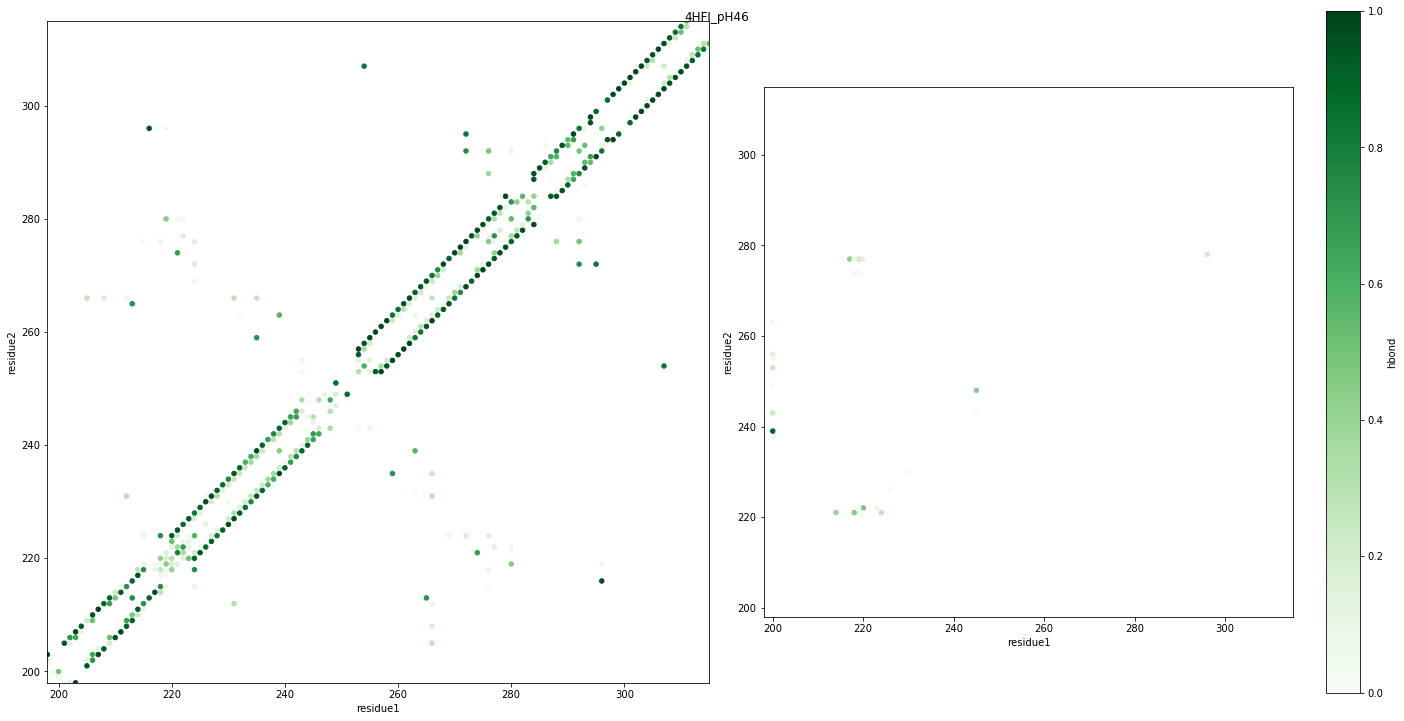

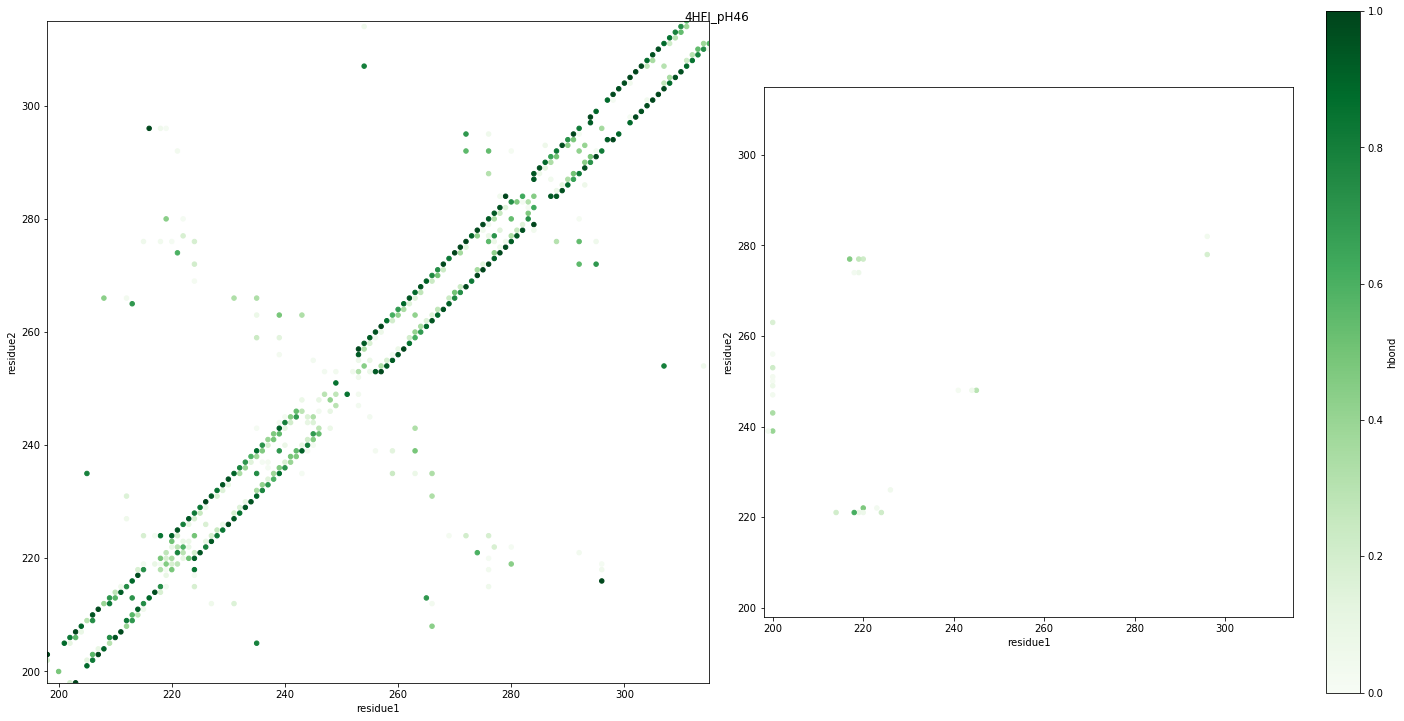

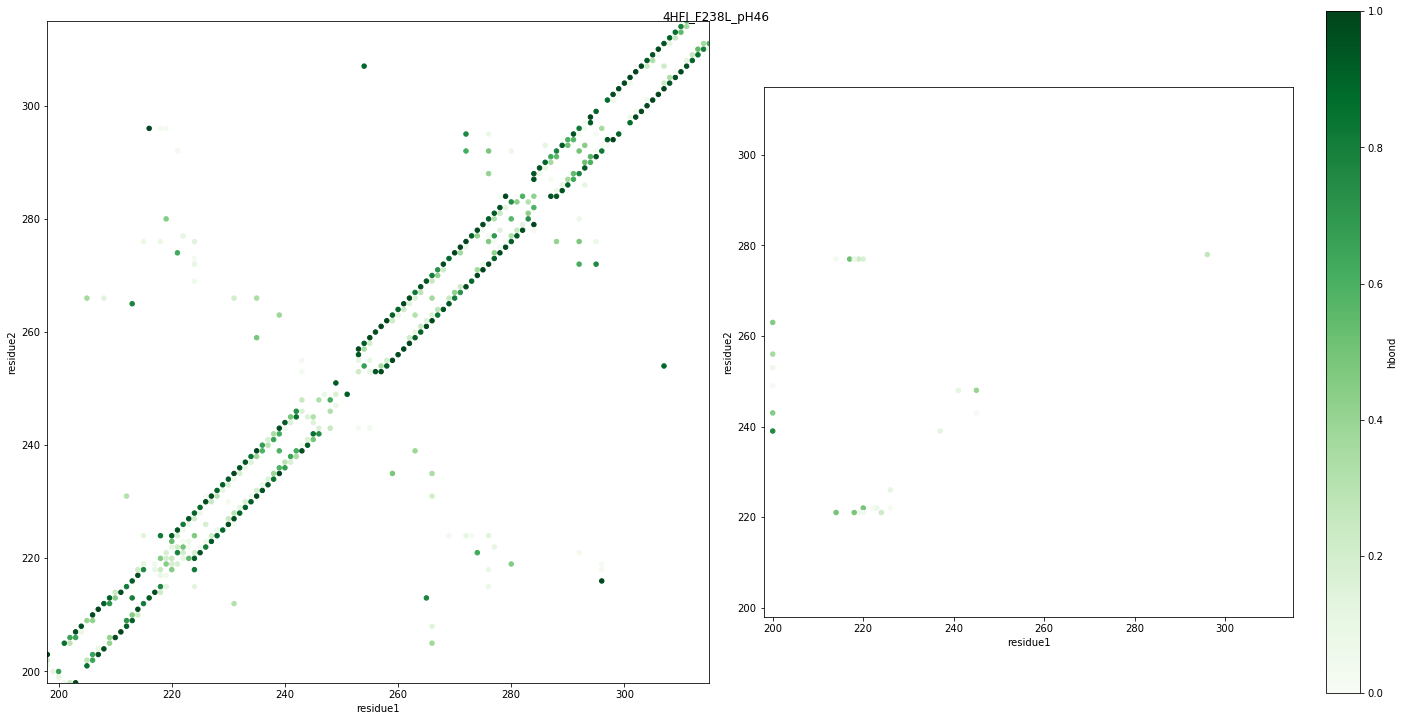

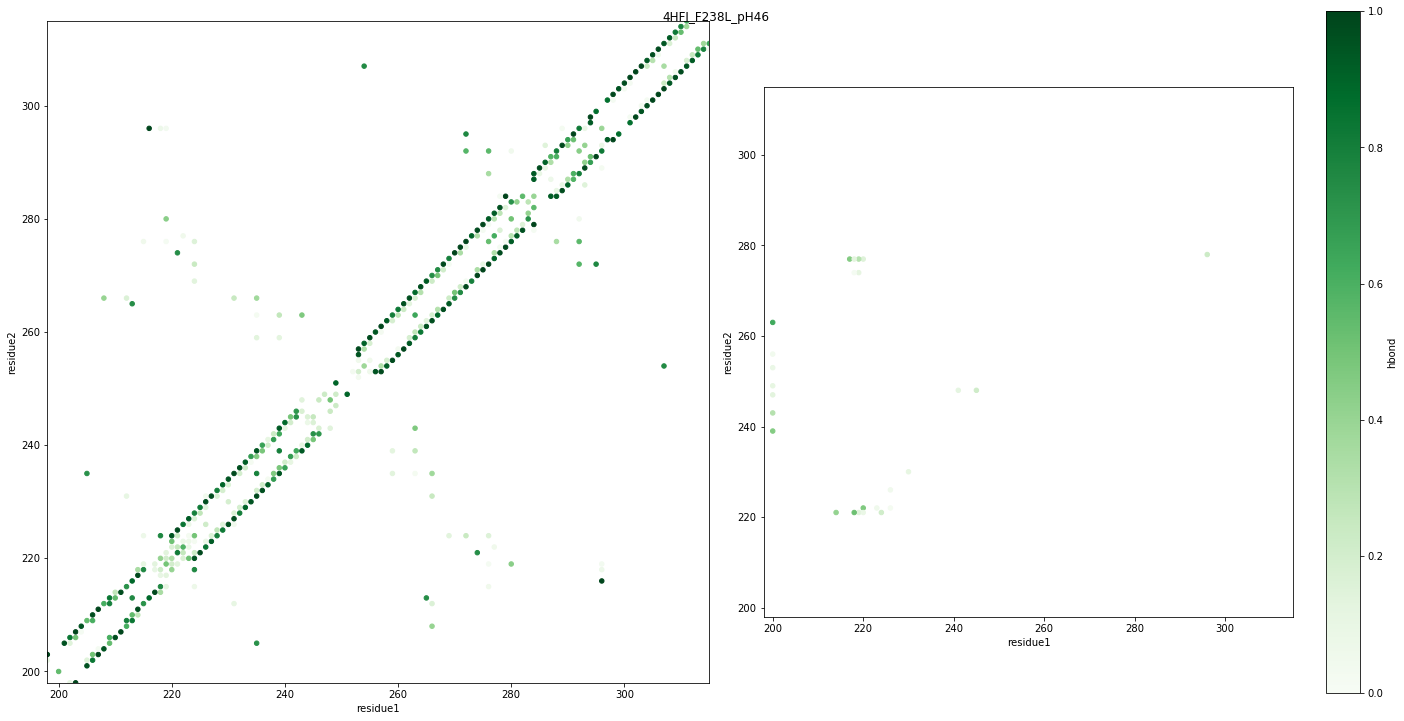

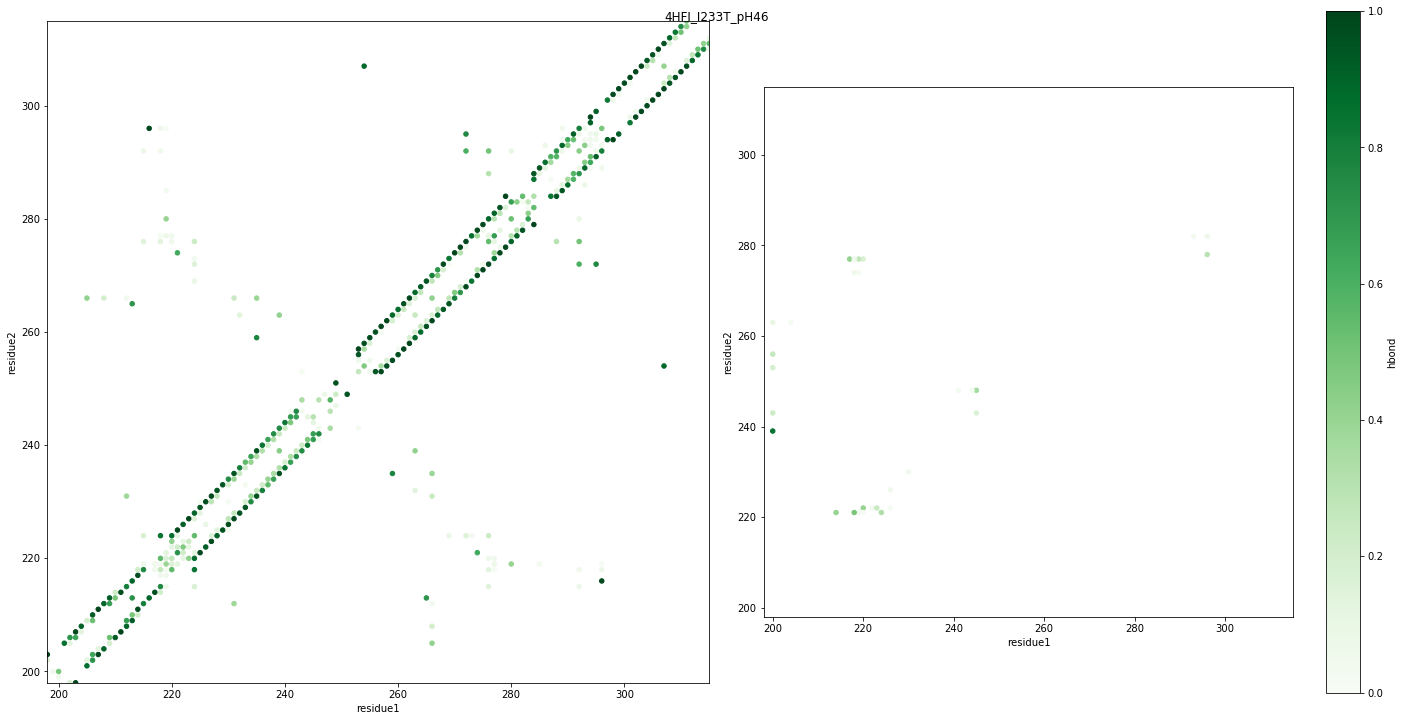

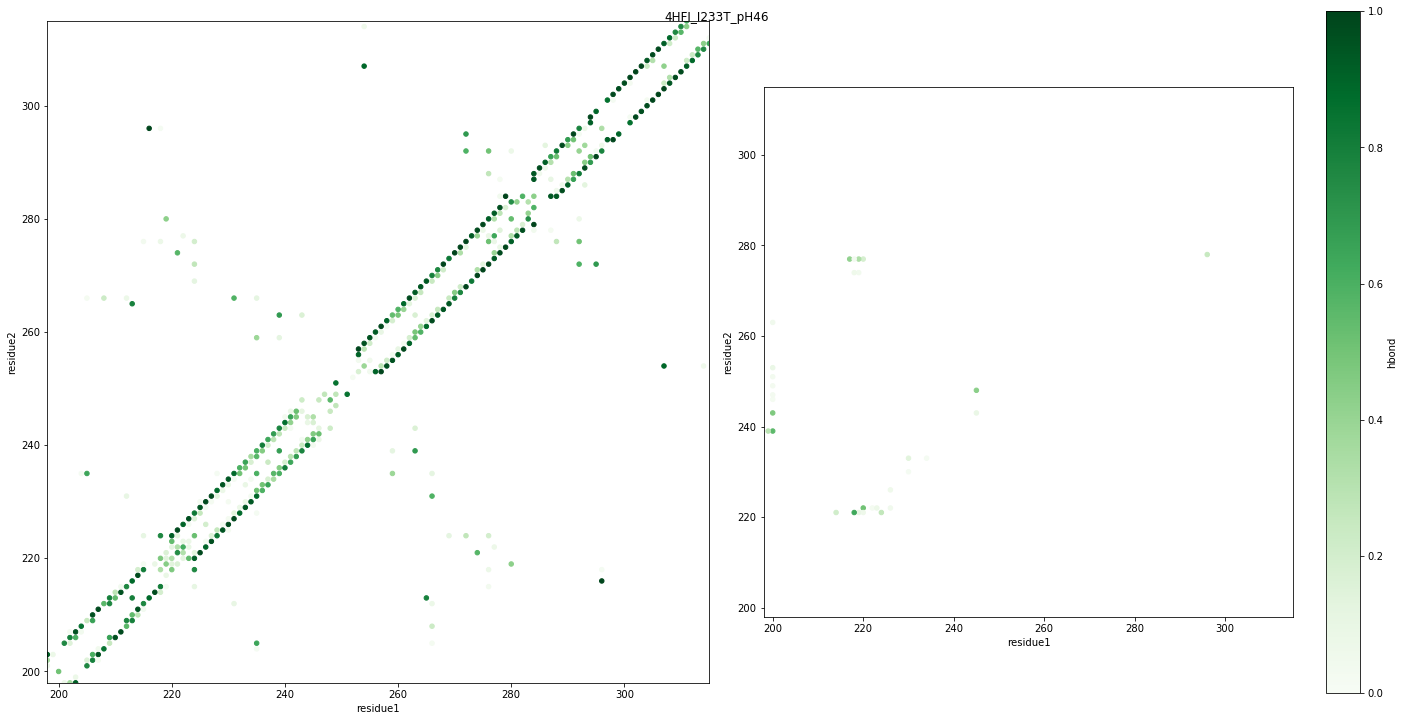

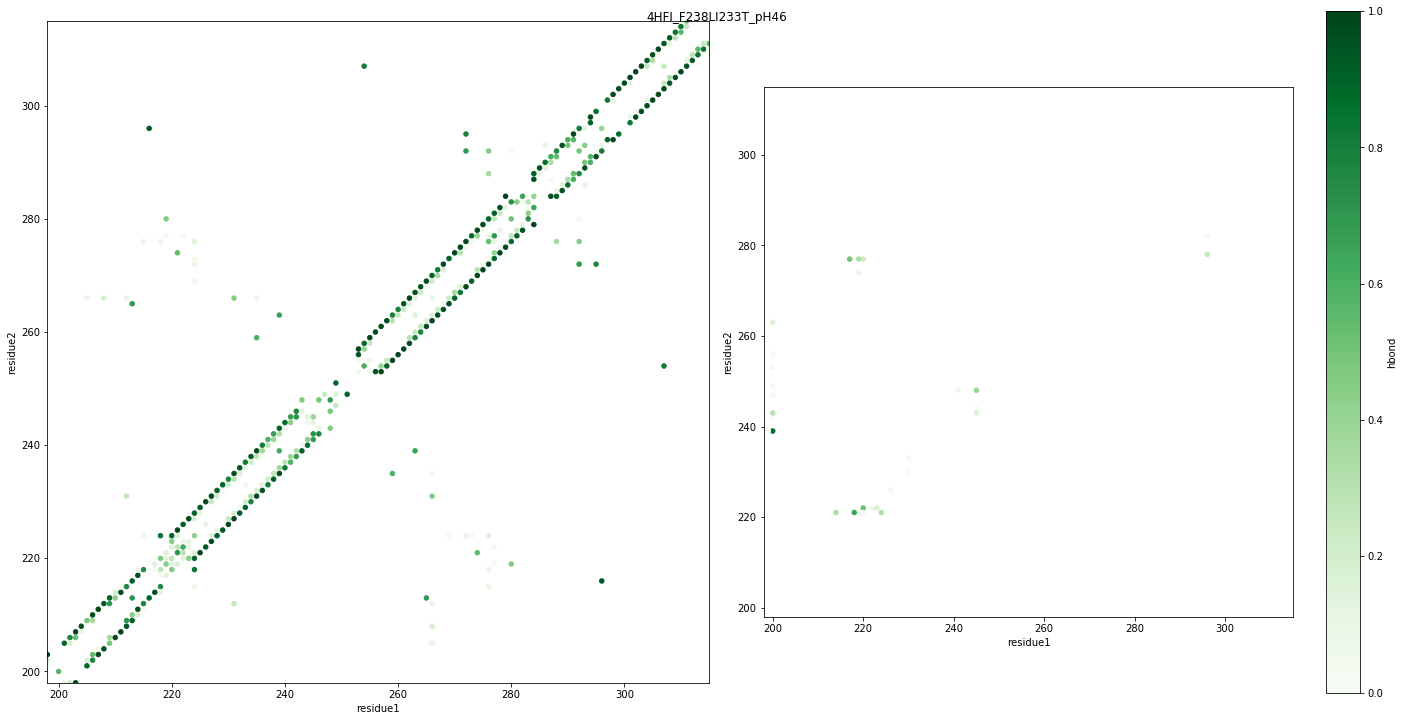

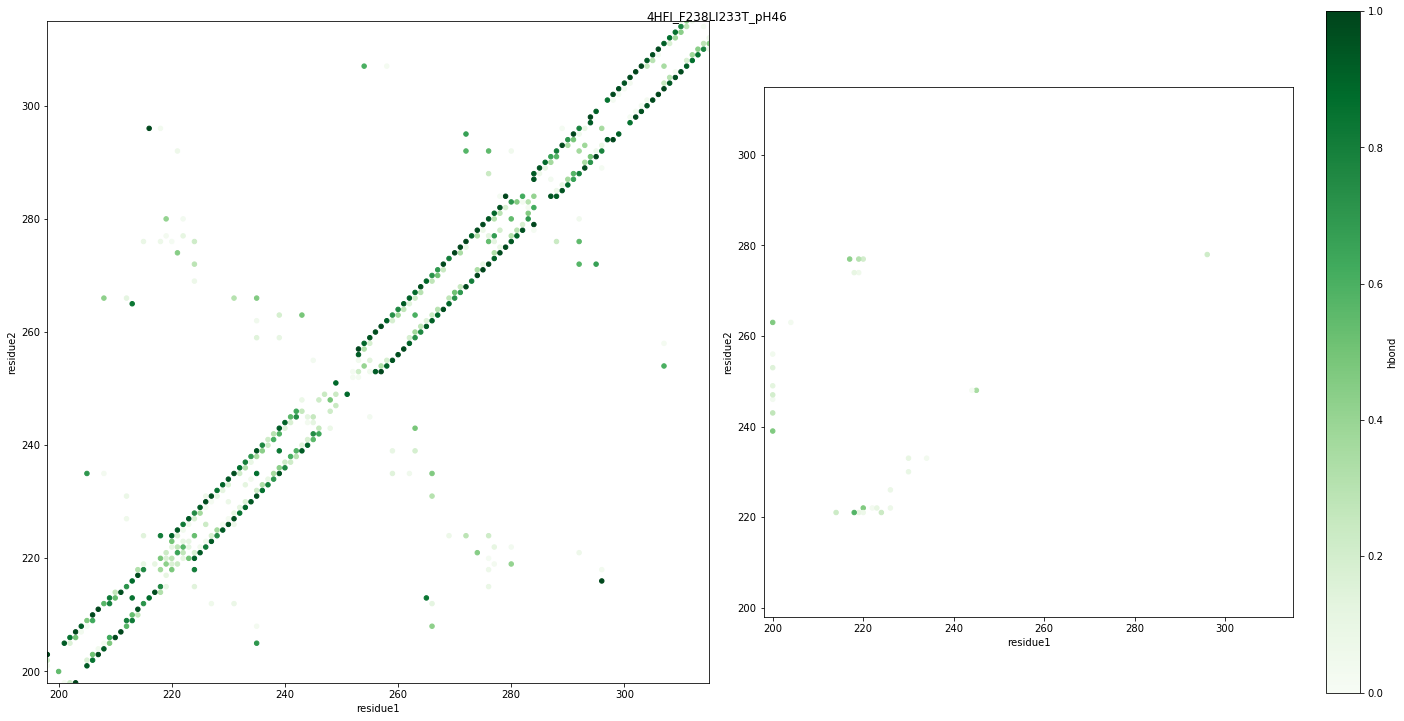

In [27]:
#789
for traj_notes in traj_notess:
    plot_inter_intra_hbond(traj_notes)

In [28]:
def plot_interaction_difference(note1,note2,note3):
    fig = plt.figure(figsize=(20, 10)) 
    ax1 = fig.add_subplot(1,2,1,aspect='equal') 

    ax2 = fig.add_subplot(1,2,2,aspect='equal')

    #ax3 = fig.add_subplot(1,3,3) 
    plot_inter_interaction_difference(note1,note2,note3,ax1)
    plot_intra_interaction_difference(note1,note2,note3,ax2)
    #plt3 = plot_salt_bridge_interaction(data,ax3)

    ax1.set_xlim(198,315)
    ax1.set_ylim(198,315)
    ax2.set_xlim(198,315)
    ax2.set_ylim(198,315) 
    ax1.set_xticks(np.arange(200,320,10))
    ax1.set_yticks(np.arange(200,320,10))
    ax2.set_xticks(np.arange(200,320,10))
    ax2.set_yticks(np.arange(200,320,10))
    ax1.grid()
    ax2.grid()
    ax1.set_title('inter interaction')
    ax2.set_title('intra interaction')
    plt.suptitle(note1 + ' vs ' + note2 + ' of ' + note3)

    plt.tight_layout()
#    plt.savefig(note1 + '_' + note2 + 'diff.pdf')
    plt.show()

In [29]:
def plot_inter_interaction_difference(note1,note2,note3,ax):
    difference = 0.4

    interaction_dataframe1 = pd.read_csv(note1 + '_inter_hbond.csv')
    interaction_dataframe2 = pd.read_csv(note2 + '_inter_hbond.csv')
    for residues in (interaction_dataframe2[['residue1','residue2']].values):
        if not(interaction_dataframe1[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1])].empty):
            interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'] = (interaction_dataframe2[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1])]['hbond'].values - interaction_dataframe1[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1])]['hbond'].values)[0]
        if ((interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'].values) >= difference) & (residues[0] > 150) & (residues[1] > 150):
            print('inter: ' + str(note2) + ' of ' + str(residues))
        elif ((interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'].values) <= -difference) & (residues[0] > 150) & (residues[1] > 150):
            print('inter: ' + str(note1) + ' of ' + str(residues))
    for residues in (interaction_dataframe1[['residue1','residue2']].values):
        if interaction_dataframe2[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1])].empty:
            interaction_dataframe1.loc[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1]),'hbond'] = - (interaction_dataframe1[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1])]['hbond'])
            interaction_dataframe2 = interaction_dataframe2.append(interaction_dataframe1[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1])],ignore_index = True)
        if ((interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'].values) >= difference) & (residues[0] > 150) & (residues[1] > 150):
            print('inter: ' + str(note2) + ' of ' + str(residues))
        elif ((interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'].values) <= -difference) & (residues[0] > 150) & (residues[1] > 150):
            print('inter: ' + str(note1) + ' of ' + str(residues))
    interaction_dataframe2.plot(kind='scatter',x='residue1',y='residue2',c=interaction_dataframe2.hbond,colormap='PuOr',ax=ax,colorbar=False,vmin=-0.5, vmax=0.5)


In [30]:
def plot_intra_interaction_difference(note1,note2,note3,ax):
    difference = 0.4
    interaction_dataframe1 = pd.read_csv(note1 + '_intra_hbond.csv')
    interaction_dataframe2 = pd.read_csv(note2 + '_intra_hbond.csv')
    for residues in (interaction_dataframe2[['residue1','residue2']].values):
        if not(interaction_dataframe1[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1])].empty):
            interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'] = (interaction_dataframe2[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1])]['hbond'].values - interaction_dataframe1[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1])]['hbond'].values)[0]
        if ((interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'].values) >= difference) & (residues[0] > 150) & (residues[1] > 150):
            print('intra: ' + str(note2) + ' of ' + str(residues))
        elif ((interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'].values) <= -difference) & (residues[0] > 150) & (residues[1] > 150):
            print('intra: ' + str(note1) + ' of ' + str(residues))
    for residues in (interaction_dataframe1[['residue1','residue2']].values):
        if interaction_dataframe2[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1])].empty:
            interaction_dataframe1.loc[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1]),'hbond'] = - (interaction_dataframe1[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1])]['hbond'])
            interaction_dataframe2 = interaction_dataframe2.append(interaction_dataframe1[(interaction_dataframe1['residue1'] == residues[0]) & (interaction_dataframe1['residue2'] == residues[1])],ignore_index = True)
        if ((interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'].values) >= difference) & (residues[0] > 150) & (residues[1] > 150):
            print('intra: ' + str(note2) + ' of ' + str(residues))
        elif ((interaction_dataframe2.loc[(interaction_dataframe2['residue1'] == residues[0]) & (interaction_dataframe2['residue2'] == residues[1]),'hbond'].values) <= -difference) & (residues[0] > 150) & (residues[1] > 150):
            print('intra: ' + str(note1) + ' of ' + str(residues))

    interaction_dataframe2.plot(kind='scatter',x='residue1',y='residue2',c=interaction_dataframe2.hbond,colormap='PuOr',ax=ax,colorbar=False,vmin=-0.5, vmax=0.5)


intra: 4HFI_F238L_pH46_md4 of [243 263]
intra: 4HFI_F238L_pH46_md4 of [235 205]
intra: 4HFI_F238L_pH46_md4 of [235 235]
intra: 4HFI_F238L_pH46_md4 of [205 235]
intra: 4HFI_F238L_pH46_md4 of [263 243]


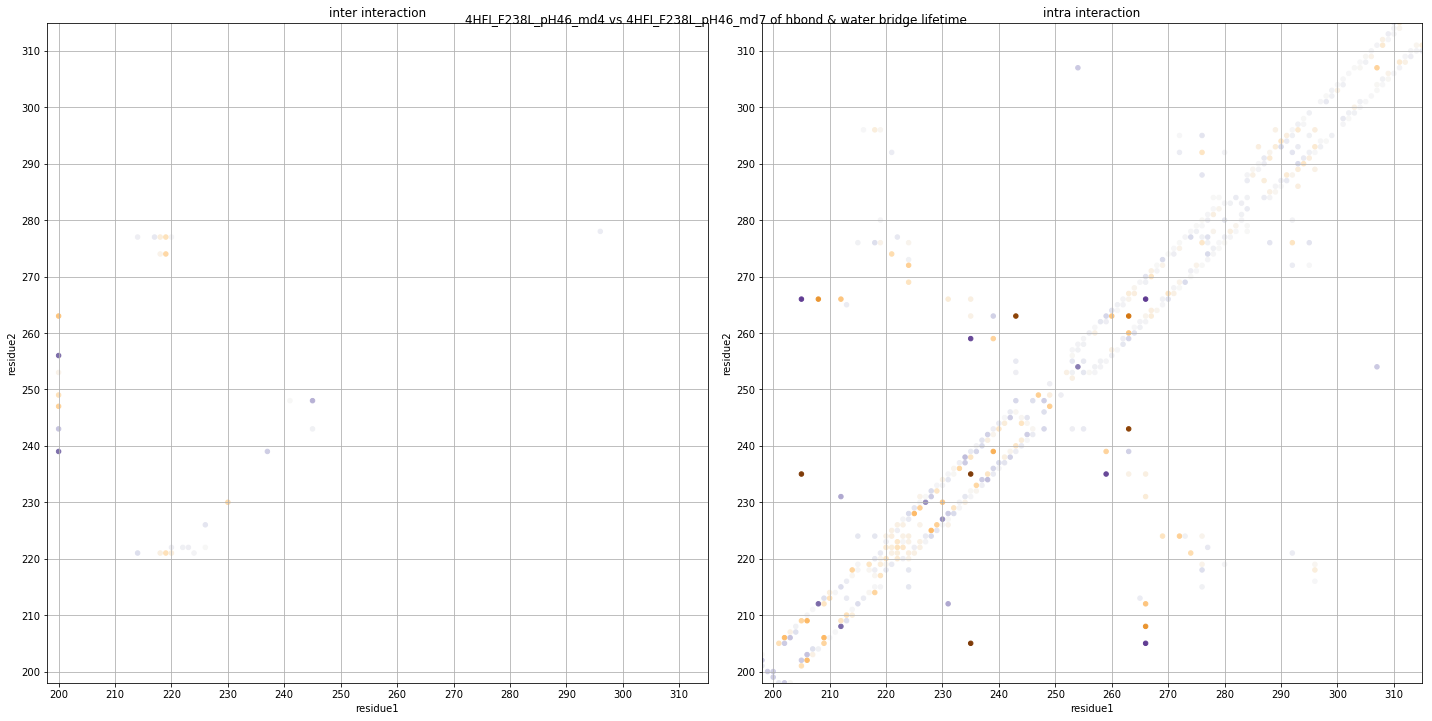

In [31]:
plot_interaction_difference('4HFI_F238L_pH46_md4','4HFI_F238L_pH46_md7','hbond & water bridge lifetime')

inter: 4HFI_pH46_md4 of [200 239]
inter: 4HFI_pH46_md4 of [200 239]
intra: 4HFI_pH46_md4 of [208 212]
intra: 4HFI_pH46_md4 of [212 208]
intra: 4HFI_pH46_md4 of [235 259]
intra: 4HFI_pH46_md4 of [259 235]
intra: 4HFI_pH46_md4 of [208 212]
intra: 4HFI_pH46_md7 of [235 205]
intra: 4HFI_pH46_md7 of [235 235]
intra: 4HFI_pH46_md7 of [205 235]
intra: 4HFI_pH46_md4 of [212 208]
intra: 4HFI_pH46_md4 of [235 259]
intra: 4HFI_pH46_md4 of [259 235]


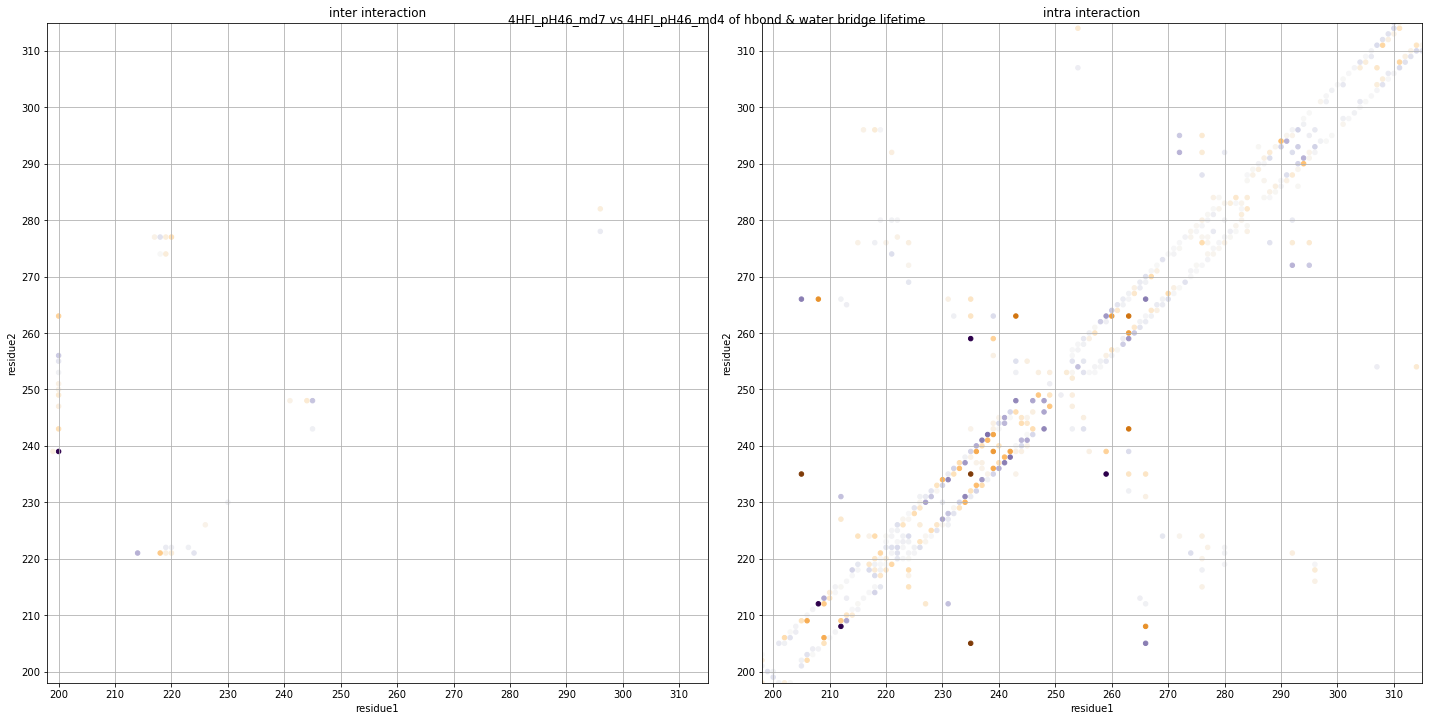

In [32]:
plot_interaction_difference('4HFI_pH46_md7','4HFI_pH46_md4','hbond & water bridge lifetime')

intra: 4HFI_I233T_pH46_md4 of [266 266]
intra: 4HFI_I233T_pH46_md7 of [235 205]
intra: 4HFI_I233T_pH46_md7 of [235 235]
intra: 4HFI_I233T_pH46_md7 of [205 235]


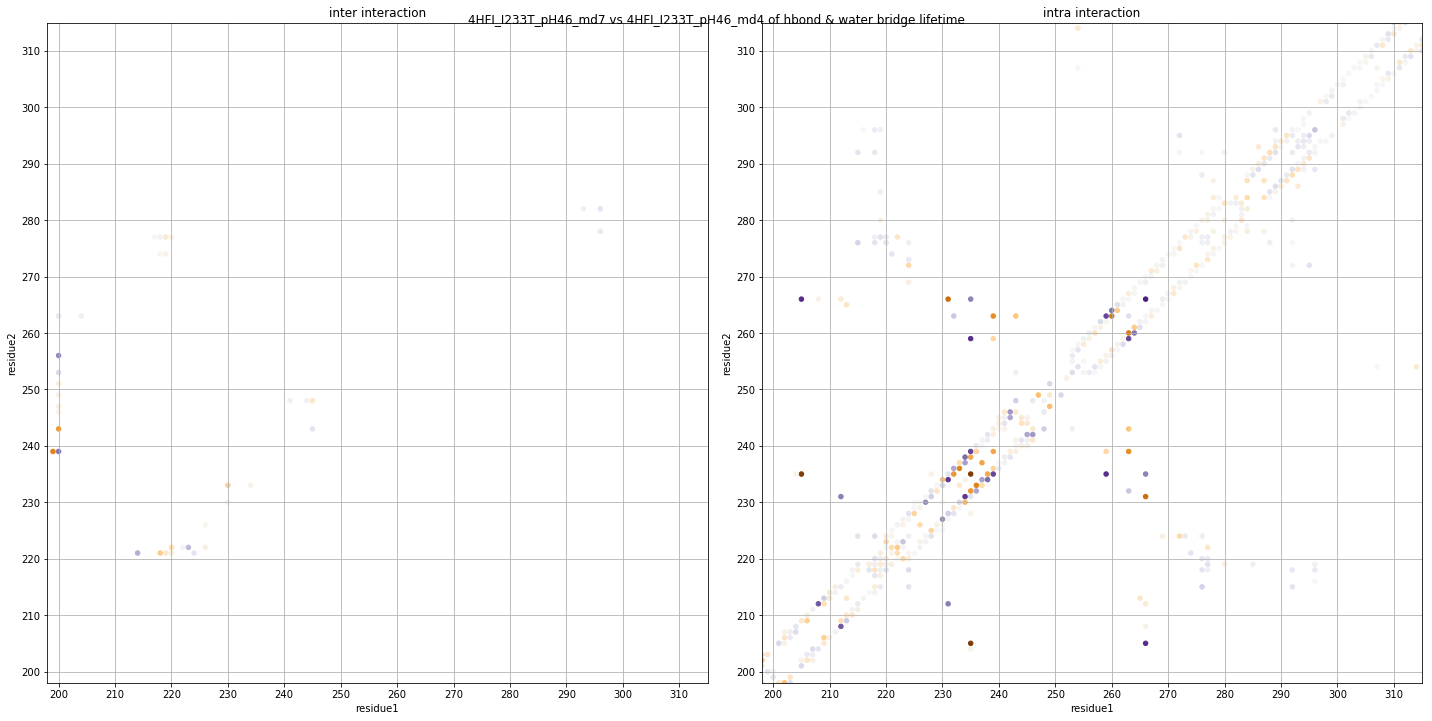

In [33]:
plot_interaction_difference('4HFI_I233T_pH46_md7','4HFI_I233T_pH46_md4','hbond & water bridge lifetime')

inter: 4HFI_F238LI233T_pH46_md4 of [200 239]
inter: 4HFI_F238LI233T_pH46_md4 of [200 239]
intra: 4HFI_F238LI233T_pH46_md7 of [263 263]
intra: 4HFI_F238LI233T_pH46_md4 of [235 259]
intra: 4HFI_F238LI233T_pH46_md4 of [239 263]
intra: 4HFI_F238LI233T_pH46_md4 of [263 239]
intra: 4HFI_F238LI233T_pH46_md4 of [259 235]
intra: 4HFI_F238LI233T_pH46_md7 of [243 263]
intra: 4HFI_F238LI233T_pH46_md7 of [235 205]
intra: 4HFI_F238LI233T_pH46_md7 of [263 263]
intra: 4HFI_F238LI233T_pH46_md7 of [235 235]
intra: 4HFI_F238LI233T_pH46_md7 of [205 235]
intra: 4HFI_F238LI233T_pH46_md4 of [235 259]
intra: 4HFI_F238LI233T_pH46_md7 of [263 243]
intra: 4HFI_F238LI233T_pH46_md4 of [239 263]
intra: 4HFI_F238LI233T_pH46_md4 of [263 239]
intra: 4HFI_F238LI233T_pH46_md4 of [259 235]


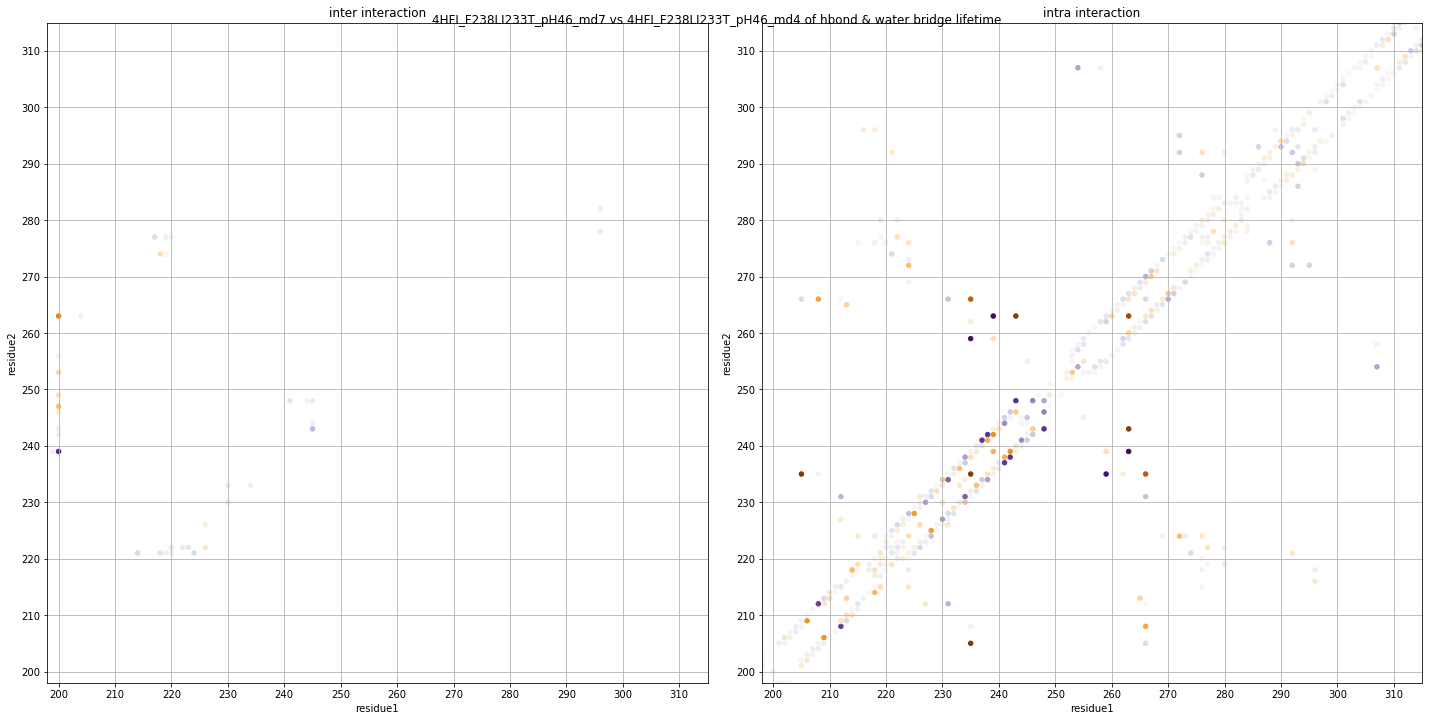

In [34]:
plot_interaction_difference('4HFI_F238LI233T_pH46_md7','4HFI_F238LI233T_pH46_md4','hbond & water bridge lifetime')

### Step 9 Geometric features

In [157]:
md_traj = md.load(default_location + '4NPQ_pH70_md5/4NPQ_pH70_md5.skip10.protein.xtc',top =default_location + '4NPQ_pH70_md5/4NPQ_pH70_md5.protein.gro' )
angle_feat = DihedralFeaturizer()
angle_feat_describe = pd.DataFrame(angle_feat.describe_features(md_traj))
angle_feat_describe = angle_feat_describe.drop(index= angle_feat_describe[angle_feat_describe.resseqs == '[315, 5]'].index)
angle_feat_describe.to_pickle('dihedral_angle_feat_describe.pickle')

In [158]:
angle_feat_describe = pd.read_pickle('dihedral_angle_feat_describe.pickle')
for index,row in angle_feat_describe.iterrows():
    md_data[str(row.featuregroup) + '_' + str(row.otherinfo) + str(row.resseqs)] = 0
traj_list = []
for traj_note in traj_notes:
    traj_list.append(md.load(default_location + traj_note + '/' + traj_note + '.skip10.protein.xtc',top =default_location + traj_note + '/' + traj_note + '.protein.gro'))
angle_features = angle_feat.fit_transform(traj_list)

In [159]:
angle_features = np.delete(np.vstack(angle_features).reshape(md_data.shape[0],4,1554),[310, 621, 932, 1243],2)

In [160]:
md_data = md_data.drop(columns = ['phi_sin[315, 5]','phi_cos[315, 5]','psi_sin[315, 5]','psi_cos[315, 5]'])

In [161]:
md_data.iloc[:,39:] = np.mean(angle_features.reshape(md_data.shape[0],5,310*4),axis=1)

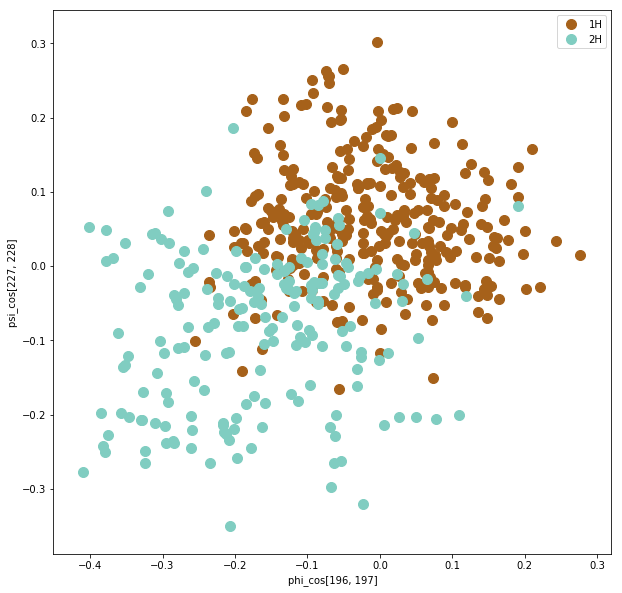

In [189]:
feature1 = 'phi_cos[196, 197]'
feature2 = 'psi_cos[227, 228]'
fig, axes = plt.subplots(1,1,figsize=(10,10))

md_data[md_data.system == 0].plot(kind='scatter',x=feature1,y=feature2,c='#a6611a',ax=axes,s=100)
md_data[md_data.system == 1].plot(kind='scatter',x=feature1,y=feature2,c='#80cdc1',ax=axes,s=100)
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], marker='o', color='#a6611a', label='Scatter',
                        markersize=10,linewidth= 0),
                Line2D([0], [0], marker='o', color='#80cdc1', label='Scatter',
                           markersize=10,linewidth= 0),]
axes.legend(custom_lines, ['1H', '2H'])

#plt.savefig('dihedral.pdf')
plt.show()

In [187]:
from sklearn.svm import SVC
import os

clf = SVC(kernel="linear")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(md_data.iloc[:,39:])
Y = md_data['system']
X = scaler.transform(md_data.iloc[:,39:])
#X = md_data.iloc[:,39:]
clf.fit(X,Y)
for ind in (-abs(clf.coef_)).argsort()[0][:10]:
    print(md_data.columns[39+ind])
    print(clf.coef_.T[ind][0])

phi_cos[196, 197]
-0.0332567032846
psi_cos[227, 228]
-0.0317123782872
phi_cos[168, 169]
0.0311340897908
phi_sin[200, 201]
0.0308133169797
phi_sin[204, 205]
0.0305872497999
psi_cos[168, 169]
-0.0294668534695
psi_cos[196, 197]
0.028534645298
phi_cos[248, 249]
-0.028115881737
phi_sin[228, 229]
0.0268269847575
phi_cos[195, 196]
-0.0265335664588


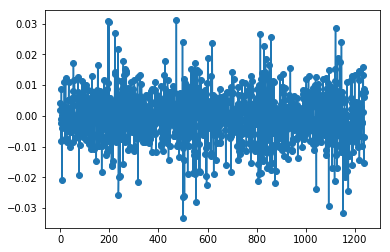

In [188]:
ax = plt.subplot()
plt.plot(clf.coef_.T,marker='o')
plt.show()